In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# Utah

## VEST Documentation

Election results from OpenElections (https://github.com/openelections/openelections-data-ut/tree/master/2020).
Precinct shapefile from Utah Automated Geographic Reference Center (https://gis.utah.gov/data/political/voter-precincts/).

The shapefile from the AGRC is of subprecincts, breaking down precincts in cases of district splits. In some cases, results are reported at the subprecinct level, in most cases, they weren't, so merging was done where necessary.

Emery County - 52 "canvas votes" were distributed to precincts.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREIPIE - Brock Pierce (Unaffiliated)  
G20PREIWES - Kanye West (Unaffiliated)  
G20PREIMCH - Joe McHugh (Unaffiliated)  
G20PREILAR - Gloria La Riva (Unaffiliated)  
G20PREOWRI - Write-in Votes  

G20GOVRCOX - Spencer J. Cox (Republican Party)  
G20GOVDPET - Chris Peterson (Democratic Party)  
G20GOVLCOT - Daniel Rhead Cottam (Libertarian Party)  
G20GOVADUE - Greg Duerden (Independent American Party)  
G20GOVOWRI - Write-in Votes  

G20ATGRREY - Sean D. Reyes (Republican Party)  
G20ATGDSKO - Greg Skordas (Democratic Party)  
G20ATGLBAU - Rudy J. Bautista (Libertarian Party)  

G20AUDRDOU - John "Frugal" Dougall (Republican Party)  
G20AUDCOST - Jeffrey L. Ostler (Constitution Party)  
G20AUDUFAB - Brian L. Fabbi (United Utah Party)  

G20TRERDAM - David Damschen (Republican Party)  
G20TRELSPE - Joseph Speciale (Libertarian Party)  
G20TRECPRO - Richard Proctor (Constitution Party)  

## Load VEST File

In [2]:
vest_ut_20 = gp.read_file("./raw-from-source/VEST/ut_2020/ut_2020.shp")

In [3]:
#Create a list of data columns
data_columns = [col for col in vest_ut_20.columns if "G20" in col]

## Load Election Results

In [4]:
#Read in Election Results
election_results = pd.read_csv("./raw-from-source/Election_Results/openelections-data-ut-master/2020/20201103__ut__general__precinct.csv")

#Filter down to relevant races
election_results = election_results[election_results["office"].isin(['President','Governor', 'Attorney General','State Auditor', 'State Treasurer'])]

#Create a column with the office and the candidate name
election_results["cand_detailed"] = election_results["office"]+"-"++election_results["candidate"].str.upper()
election_results["cand_detailed"] = election_results["cand_detailed"].astype(str)

#Filter out the na results
election_results = election_results[election_results["cand_detailed"]!="nan"]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
cand_rename_dict = {
 #Presidential Candidates
 'President-REP DONALD J. TRUMP':"G20PRERTRU",
 'President-DONALD J. TRUMP':"G20PRERTRU",
 'President-DONALD J. TRUMP / MICHAEL R. PENCE':"G20PRERTRU",
 'President-DONALD J. TRUMP, MICHAEL R. PENCE':"G20PRERTRU",
    
 'President-JOSEPH R. BIDEN':"G20PREDBID",
 'President-JOSEPH R. BIDEN / KAMALA D. HARRIS':"G20PREDBID",
 'President-JOSEPH R. BIDEN, KAMALA D. HARRIS':"G20PREDBID",
 'President-DEM JOSEPH R. BIDEN':"G20PREDBID", 

 'President-JO JORGENSEN':"G20PRELJOR",
 'President-JO JORGENSEN / JEREMY COHEN':"G20PRELJOR",
 'President-JO JORGENSEN, JEREMY COHEN':"G20PRELJOR",
 'President-LIB JO JORGENSEN':"G20PRELJOR",
    
 'President-HOWIE HAWKINS':"G20PREGHAW",
 'President-HOWIE HAWKINS / ANGELA WALKER':"G20PREGHAW",
 'President-HOWIE HAWKINS, ANGELA WALKER':"G20PREGHAW",
 'President-GRN HOWIE HAWKINS':"G20PREGHAW",
    
 'President-CON DON BLANKENSHIP':"G20PRECBLA",
 'President-DON BALLOTS CAST BLANKENSHIP':"G20PRECBLA",
 'President-DON BLANKENSHIP':"G20PRECBLA",
 'President-DON BLANKENSHIP / WILLIAM MOHR':"G20PRECBLA",
 'President-DON BLANKENSHIP, WILLIAM MOHR':"G20PRECBLA",
    
 'President-BROCK PIERCE':"G20PREIPIE",
 'President-BROCK PIERCE / KARLA BALLARD':"G20PREIPIE",
 'President-BROCK PIERCE, KARLA BALLARD':"G20PREIPIE",
    
 'President-KANYE WEST':"G20PREIWES",
 'President-KANYE WEST / MICHELLE TIDBALL':"G20PREIWES",
 'President-KANYE WEST, MICHELLE TIDBALL':"G20PREIWES",
    
 'President-JOE MCHUGH':"G20PREIMCH",
 'President-JOE MCHUGH / ELIZABETH STORM':"G20PREIMCH",
 'President-JOE MCHUGH, ELIZABETH STORM':"G20PREIMCH",
    
 'President-GLORIA LA RIVA':"G20PREILAR",
 'President-GLORIA LARIVA':"G20PREILAR",
    
 'President-BRIAN CARROLL':"G20PREOWRI",
 'President-BRIAN CARROLL (W)':"G20PREOWRI",
 'President-WRITE-IN: BRIAN CARROLL':"G20PREOWRI",
 'President-WRITE-IN~ BRIAN CARROLL':"G20PREOWRI",
 'President-WRITE-IN~ JADE SIMMONS':"G20PREOWRI",
 'President-JADE SIMMONS (W)':"G20PREOWRI",
 'President-JADE SIMMONS / CLAUDELIAH J. ROZE':"G20PREOWRI",
 'President-WRITE-IN: JADE':"G20PREOWRI",
 'President-WRITE-IN: JADE SIMMONS':"G20PREOWRI",
 'President-KATHERINE FORBES':"G20PREOWRI",
 'President-PRESIDENT R. BODDIE (W)':"G20PREOWRI",
 'President-PRESIDENT R. BODDIE / ERIC C. STONEHAM':"G20PREOWRI",
 'President-PRINCESS KHADIJAH M. JACOB-FAMBRO (W)':"G20PREOWRI",
 'President-PRINCESS KHADIJAH M. JACOB-FAMBRO / KHADIJAH MARYAM JACOB SR.':"G20PREOWRI",
 'President-TOM HOEFLING':"G20PREOWRI",
 'President-TOM HOEFLING (W)':"G20PREOWRI",
 'President-WRITE-IN: TOM HOEFLING':"G20PREOWRI",
 'President-WRITE-IN':"G20PREOWRI",
 'President-WRITE-IN TOTALS':"G20PREOWRI",
 'President-WRITE-IN: UN-REGISTERED WRITE IN':"G20PREOWRI",
 'President-WRITE-INS':"G20PREOWRI",

 #EXPERIMENT HERE w/ including
 'President-WRITE-IN: INVALID':"G20PREOWRI",
 'President-WRITE-IN: NOT CERTIFIED':"G20PREOWRI",   
 'President-NOT ASSIGNED':"G20PREOWRI",
    
 #Gubernatorial Candidates
 'Governor-CHRIS PETERSEN':"G20GOVDPET",
 'Governor-CHRIS PETERSON':"G20GOVDPET",
 'Governor-CHRIS PETERSON / KARINA BROWN':"G20GOVDPET",
 'Governor-CHRIS PETERSON, KARINA BROWN':"G20GOVDPET",
 'Governor-DEM CHRIS PETERSON':"G20GOVDPET",
    
 'Governor-DANIEL RHEAD COTTAM':"G20GOVLCOT",
 'Governor-DANIEL RHEAD COTTAM / BARRY EVAN SHORT':"G20GOVLCOT",
 'Governor-DANIEL RHEAD COTTAM, BARRY EVAN SHORT':"G20GOVLCOT",
 'Governor-LIB DANIEL RHEAD COTTAM':"G20GOVLCOT",
 
 'Governor-GREG DUERDEN':"G20GOVADUE",
 'Governor-GREG DUERDEN / WAYNE HILL':"G20GOVADUE",
 'Governor-GREG DUERDEN, WAYNE HILL':"G20GOVADUE",
 'Governor-IAP GREG DUERDEN':"G20GOVADUE",
    
 'Governor-REP SPENCER J. COX':"G20GOVRCOX",
 'Governor-SPENCER J. COX':"G20GOVRCOX",
 'Governor-SPENCER J. COX / DEIDRE M. HENDERSON':"G20GOVRCOX",
 'Governor-SPENCER J. COX, DEIDRE M. HENDERSON':"G20GOVRCOX",
    
 'Governor-GREGORY C. JOHNSON (W)':"G20GOVOWRI",

 'Governor-KRISTENA M. CONLIN':"G20GOVOWRI",
 'Governor-KRISTENA M. CONLIN (W)':"G20GOVOWRI",
 'Governor-WRITE-IN~ KRISTENA M CONLIN':"G20GOVOWRI",
 'Governor-WRITE-IN: KRISTENA M. CONLIN':"G20GOVOWRI", 
    
 'Governor-MADELINE KAZANTZIS':"G20GOVOWRI",
 'Governor-MADELINE KAZANTZIS / ED KENNEDY':"G20GOVOWRI",
 'Governor-WRITE-IN: MADELINE KAZANTZIS':"G20GOVOWRI",
 'Governor-WRITE-IN: MADELINE KAZANTZIS ED KENNEDY':"G20GOVOWRI",
 'Governor-WRITE-IN: MADELINE KAZANTZIS, ED':"G20GOVOWRI",
 'Governor-WRITE-IN: MADELINE KAZANTZIS/ED':"G20GOVOWRI",
 'Governor-WRITE-IN~ MADELINE KAZANTZIS':"G20GOVOWRI",
     
 'Governor-RICHARD T. WHITNEY':"G20GOVOWRI",
 'Governor-RICHARD T. WHITNEY (W)':"G20GOVOWRI",
 'Governor-WRITE-IN: RICHARD T. WHITNEY':"G20GOVOWRI",
 'Governor-WRITE-IN~ RICHARD T. WHITNEY':"G20GOVOWRI",

 'Governor-TYLER SCOTT BATTY (W)':"G20GOVOWRI",
 'Governor-TYLER SCOTT BATTY / GREGORY C. JOHNSON':"G20GOVOWRI",
 'Governor-WRITE-IN: TYLER SCOTT BAILEY':"G20GOVOWRI",
 
 'Governor-WRITE-IN':"G20GOVOWRI",
 'Governor-WRITE-IN TOTALS':"G20GOVOWRI",
 'Governor-WRITE-IN: UN-REGISTERED WRITE-IN':"G20GOVOWRI",
 'Governor-WRITE-INS':"G20GOVOWRI",

 #EXPERIMENT HERE w/ including
 'Governor-NOT ASSIGNED':"G20GOVOWRI",
 'Governor-WRITE-IN: INVALID':"G20GOVOWRI",
 'Governor-WRITE-IN: NOT CERTIFIED':"G20GOVOWRI", 
    
 #Attorney General Candidates
 'Attorney General-DEM GREG SKORDAS':'G20ATGDSKO',
 'Attorney General-GREG SKORDAS':'G20ATGDSKO',
 'Attorney General-LIB RUDY J. BAUTISTA':'G20ATGLBAU',
 'Attorney General-REP SEAN D. REYES':'G20ATGRREY',
 'Attorney General-RUDY J. BAUTISTA':'G20ATGLBAU',
 'Attorney General-SEAN D. REYES':'G20ATGRREY',
    
 #Auditor Candidates
 'State Auditor-BRIAN L. FABBI':'G20AUDUFAB',
 'State Auditor-CON JEFFREY L. OSTLER':'G20AUDCOST',
 'State Auditor-JEFFREY L. OSTLER':'G20AUDCOST',
 'State Auditor-JOHN "FRUGAL" DOUGALL':'G20AUDRDOU',
 'State Auditor-JOHN "FRUGAL\' DOUGALL':'G20AUDRDOU',
 "State Auditor-JOHN 'FRUGAL' DOUGALL":'G20AUDRDOU',
 "State Auditor-REP JOHN 'FRUGAL' DOUGALL":'G20AUDRDOU',
 'State Auditor-UUP BRIAN L. FABBI':'G20AUDUFAB',

 #Treasurer Candidates
 'State Treasurer-CON RICHARD PROCTOR':'G20TRECPRO',
 'State Treasurer-DAVID DAMSCHEN':'G20TRERDAM',
 'State Treasurer-DAVID DAMSHEN':'G20TRERDAM',
 'State Treasurer-JOSEPH SPECIALE':'G20TRELSPE',
 'State Treasurer-LIB JOSEPH SPECIALE':'G20TRELSPE',
 'State Treasurer-REP DAVID DAMSCHEN':'G20TRERDAM',
 'State Treasurer-RICHARD PROCTOR':'G20TRECPRO', 
}

In [6]:
#Apply the candidate rename dictionary
election_results["cand_detailed"] = election_results["cand_detailed"].map(cand_rename_dict).fillna(election_results["cand_detailed"])
election_results = election_results[election_results["cand_detailed"]!="DROP"]

#Check that it matches
election_results["cand_detailed"].unique()

array(['G20PREIPIE', 'G20PREIWES', 'G20PREDBID', 'G20PRECBLA',
       'G20PRELJOR', 'G20PREIMCH', 'G20PREGHAW', 'G20PREILAR',
       'G20PRERTRU', 'G20PREOWRI', 'G20GOVDPET', 'G20GOVADUE',
       'G20GOVRCOX', 'G20GOVLCOT', 'G20GOVOWRI', 'G20ATGLBAU',
       'G20ATGDSKO', 'G20ATGRREY', 'G20AUDRDOU', 'G20AUDCOST',
       'G20AUDUFAB', 'G20TRECPRO', 'G20TRERDAM', 'G20TRELSPE'],
      dtype=object)

In [7]:
#Create a pivot column
election_results["pivot_col"] = election_results["county"]+"-"+election_results["precinct"]

#Clean up this column
election_results["votes"] = election_results["votes"].astype(str)
election_results["votes"] = election_results["votes"].str.replace(",","")
election_results["votes"] = election_results["votes"].astype(int)

#Perform the pivot
election_results_pivot = pd.pivot_table(election_results,values="votes",index=["pivot_col","county","precinct"],columns=["cand_detailed"],aggfunc=sum)

#Clean up the columns / indices
election_results_pivot.reset_index(inplace=True,drop=False)
election_results_pivot.reset_index(inplace=True,drop=True)

#Take a look
election_results_pivot

cand_detailed,pivot_col,county,precinct,G20ATGDSKO,G20ATGLBAU,G20ATGRREY,G20AUDCOST,G20AUDRDOU,G20AUDUFAB,G20GOVADUE,G20GOVDPET,G20GOVLCOT,G20GOVOWRI,G20GOVRCOX,G20PRECBLA,G20PREDBID,G20PREGHAW,G20PREILAR,G20PREIMCH,G20PREIPIE,G20PREIWES,G20PRELJOR,G20PREOWRI,G20PRERTRU,G20TRECPRO,G20TRELSPE,G20TRERDAM
0,Beaver-BEAVER 1,Beaver,BEAVER 1,56.0,18.0,629.0,51.0,603.0,15.0,11.0,40.0,15.0,12.0,621.0,0.0,59.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,682.0,41.0,20.0,609.0
1,Beaver-BEAVER 2,Beaver,BEAVER 2,63.0,21.0,426.0,42.0,414.0,26.0,13.0,46.0,19.0,8.0,431.0,1.0,57.0,2.0,1.0,0.0,0.0,3.0,5.0,0.0,463.0,44.0,34.0,412.0
2,Beaver-BEAVER 3,Beaver,BEAVER 3,31.0,18.0,379.0,25.0,361.0,5.0,5.0,32.0,18.0,7.0,365.0,0.0,34.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,413.0,17.0,14.0,369.0
3,Beaver-BEAVER 4,Beaver,BEAVER 4,21.0,5.0,148.0,18.0,145.0,1.0,2.0,18.0,7.0,5.0,142.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,156.0,21.0,5.0,138.0
4,Beaver-GREENVILLE 1,Beaver,GREENVILLE 1,12.0,3.0,81.0,5.0,81.0,3.0,1.0,9.0,2.0,1.0,82.0,0.0,9.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,90.0,1.0,5.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,Weber-West Haven 004,Weber,West Haven 004,554.0,151.0,1213.0,274.0,1337.0,191.0,29.0,555.0,61.0,NaN,1252.0,3.0,652.0,9.0,1.0,4.0,2.0,11.0,52.0,NaN,1245.0,189.0,301.0,1326.0
2342,Weber-West Haven 005,Weber,West Haven 005,97.0,16.0,265.0,38.0,285.0,23.0,7.0,81.0,4.0,NaN,279.0,0.0,100.0,0.0,0.0,0.0,1.0,1.0,5.0,NaN,277.0,24.0,27.0,300.0
2343,Weber-West Haven 006,Weber,West Haven 006,61.0,13.0,397.0,26.0,395.0,22.0,8.0,54.0,11.0,NaN,387.0,1.0,71.0,0.0,0.0,2.0,0.0,2.0,10.0,NaN,386.0,25.0,33.0,391.0
2344,Weber-West Haven 007,Weber,West Haven 007,194.0,38.0,592.0,92.0,617.0,66.0,9.0,172.0,25.0,NaN,594.0,4.0,214.0,3.0,0.0,1.0,1.0,7.0,20.0,NaN,595.0,75.0,98.0,604.0


## Check Statewide Totals

In [8]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [9]:
statewide_totals_check(vest_ut_20,election_results_pivot,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 1.0 votes
	VEST: 865140 votes
	SOURCES: 865139.0 votes
G20PREDBID is equal 	VEST / RDH: 560282
G20PRELJOR is equal 	VEST / RDH: 38447
G20PREGHAW is equal 	VEST / RDH: 5053
G20PRECBLA is equal 	VEST / RDH: 5551
G20PREIPIE is equal 	VEST / RDH: 2623
G20PREIWES is equal 	VEST / RDH: 7213
G20PREIMCH is equal 	VEST / RDH: 2229
G20PREILAR is equal 	VEST / RDH: 1139
G20PREOWRI is equal 	VEST / RDH: 18965
G20GOVRCOX has a difference of 1.0 votes
	VEST: 918754 votes
	SOURCES: 918753.0 votes
G20GOVDPET is equal 	VEST / RDH: 442754
G20GOVLCOT is equal 	VEST / RDH: 51393
G20GOVADUE is equal 	VEST / RDH: 25810
G20GOVOWRI has a difference of 1.0 votes
	VEST: 38170 votes
	SOURCES: 38169.0 votes
G20ATGRREY has a difference of 1.0 votes
	VEST: 878853 votes
	SOURCES: 878852.0 votes
G20ATGDSKO is equal 	VEST / RDH: 489500
G20ATGLBAU is equal 	VEST / RDH: 82444
G20AUDRDOU has a difference of 1.0 votes
	VEST: 1000846 votes
	SOURCES: 1000845.0 vote

## Check Countywide Totals

In [10]:
#Create a mapping from CountyID to county name
county_id_dict ={'Beaver': 1,
 'Box Elder': 2,
 'Cache': 3,
 'Carbon': 4,
 'Daggett': 5,
 'Davis': 6,
 'Duchesne': 7,
 'Emery': 8,
 'Garfield': 9,
 'Grand': 10,
 'Iron': 11,
 'Juab': 12,
 'Kane': 13,
 'Millard': 14,
 'Morgan': 15,
 'Piute': 16,
 'Rich': 17,
 'Salt Lake': 18,
 'San Juan': 19,
 'Sanpete': 20,
 'Sevier': 21,
 'Summit': 22,
 'Tooele': 23,
 'Uintah': 24,
 'Utah': 25,
 'Wasatch': 26,
 'Washington': 27,
 'Wayne': 28,
 'Weber': 29}

In [11]:
election_results_pivot["CountyID"] = election_results_pivot["county"].map(county_id_dict)

In [12]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [13]:
#Fill the n/a values
election_results_pivot =election_results_pivot.fillna(0)

#Clean up the columns
election_results_pivot["CountyID"] = election_results_pivot["CountyID"].astype(str)
vest_ut_20["CountyID"] = vest_ut_20["CountyID"].astype(str)
for val in data_columns:
    election_results_pivot[val]=election_results_pivot[val].astype(int)
    vest_ut_20[val]=vest_ut_20[val].astype(int)

In [14]:
county_totals_check(vest_ut_20,election_results_pivot,data_columns,"CountyID",full_print=False)

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	7 has a difference of 1 votes
		VEST: 7513 votes
		SOURCES: 7512 votes
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREIPIE is equal across all counties
G20PREIWES is equal across all counties
G20PREIMCH is equal across all counties
G20PREILAR is equal across all counties
G20PREOWRI is equal across all counties
G20GOVRCOX contains differences in these counties:
	7 has a difference of 1 votes
		VEST: 6096 votes
		SOURCES: 6095 votes
G20GOVDPET is equal across all counties
G20GOVLCOT is equal across all counties
G20GOVADUE is equal across all counties
G20GOVOWRI contains differences in these counties:
	11 has a difference of 1 votes
		VEST: 1603 votes
		SOURCES: 1602 votes
G20ATGRREY contains differences in these counties:
	7 has a difference of 1 votes
		VEST: 7054 votes
		SOURCES: 7053 vo

In [15]:
#The below was used for the check against the official county totals
#election_results_pivot.groupby(["CountyID"]).sum().to_csv("./source_county_totals.csv")

## Precinct-by-Precinct Check

In [16]:
#Check if the unique_ID column is unique
vest_ut_20["unique_ID"] = vest_ut_20["CountyID"]+"-"+vest_ut_20["resultspre"]
vest_ut_20["unique_ID"].value_counts(dropna=False)

NaN                       83
23-T-06                    1
22-Summit Park West        1
6-Bountiful 01:I-S-        1
25-Saratoga Springs 05     1
                          ..
18-WVC044                  1
25-(Unincorporated) LV     1
18-SAN081                  1
26-54~1                    1
27-CODXDR                  1
Name: unique_ID, Length: 2342, dtype: int64

In [17]:
#All the NaN unique_ID values have 0 total votes
for i in data_columns:
    print(i)
    print(sum(vest_ut_20[vest_ut_20["unique_ID"].isna()][i]))

G20PRERTRU
0
G20PREDBID
0
G20PRELJOR
0
G20PREGHAW
0
G20PRECBLA
0
G20PREIPIE
0
G20PREIWES
0
G20PREIMCH
0
G20PREILAR
0
G20PREOWRI
0
G20GOVRCOX
0
G20GOVDPET
0
G20GOVLCOT
0
G20GOVADUE
0
G20GOVOWRI
0
G20ATGRREY
0
G20ATGDSKO
0
G20ATGLBAU
0
G20AUDRDOU
0
G20AUDCOST
0
G20AUDUFAB
0
G20TRERDAM
0
G20TRELSPE
0
G20TRECPRO
0


In [18]:
#Create a unique_ID column in the election results
election_results_pivot["unique_ID"] = election_results_pivot["CountyID"]+"-"+election_results_pivot["precinct"]

#Confirm the values are unique
election_results_pivot["unique_ID"].value_counts(dropna=False)

25-Lehi 18                1
18-KRN016                 1
22-Summit Park West       1
6-Bountiful 01:I-S-       1
25-Saratoga Springs 05    1
                         ..
26-54~1                   1
25-Provo 40               1
18-WVC028                 1
25-(Unincorporated) FF    1
27-CODXDR                 1
Name: unique_ID, Length: 2346, dtype: int64

Following VEST's documentation, allocate the votes in Emery County

In [19]:
to_allocate = election_results_pivot[election_results_pivot["unique_ID"]=="8-Canvas"]
receiving_votes = election_results_pivot[election_results_pivot["unique_ID"]!="8-Canvas"]

In [20]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [21]:
election_results = allocate_absentee(receiving_votes,to_allocate,data_columns,"CountyID")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

In [22]:
#Attempt to join the results
join_attempt_one = pd.merge(vest_ut_20,election_results,how="outer",on="unique_ID",indicator=True)
print(join_attempt_one["_merge"].value_counts())

# join_attempt_one[join_attempt_one["_merge"]=="left_only"].to_csv("./vest_only.csv")
# join_attempt_one[join_attempt_one["_merge"]=="right_only"].to_csv("./source_only.csv")

both          2319
left_only      105
right_only      26
Name: _merge, dtype: int64


In [23]:
id_changes_dict = {
'21-Monroe 1':'21-Monroe 8',
'21-Monroe 2':'21-Monroe 9',
'24-Vernal City 1':'24-Vernal City 8',
'21-Richfield 7':'21-Richfield 23',
'24-Vernal City 3':'24-Vernal City 10',
'21-Richfield 8':'21-Richfield 24',
'24-Vernal City 2':'24-Vernal City 9',
'24-Vernal City 5':'24-Vernal City 12',
'24-Vernal City 6':'24-Vernal City 13',
'21-Richfield 3':'21-Richfield 13',
'21-Salina 2':'21-Salina 15',
'21-Richfield 1':'21-Richfield 11',
'21-Richfield 6':'21-Richfield 22',
'21-Richfield 2':'21-Richfield 12',
'24-Vernal City 4':'24-Vernal City 11',
'21-Richfield 4':'21-Richfield 20',
'21-Richfield 5':'21-Richfield 21',
'21-Salina 1':'21-Salina 14',
'21-Salina 3':'21-Salina 25',
'16-Marysville':'16-Marysvale',
'24-Vernal City 7':'24-Vernal City 14',
'23-G-17:0':'23-LP-17:0',
}

In [24]:
#Apply the name changes
election_results["unique_ID"] = election_results["unique_ID"].map(id_changes_dict).fillna(election_results_pivot["unique_ID"])

<ipython-input-24-964e2a8d71f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["unique_ID"] = election_results["unique_ID"].map(id_changes_dict).fillna(election_results_pivot["unique_ID"])


In [25]:
#Join again
join_attempt_two = pd.merge(vest_ut_20,election_results,how="outer",on="unique_ID",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          2341
left_only       83
right_only       4
Name: _merge, dtype: int64


In [26]:
#Confirm the unjoined results have zero total votes
for i in data_columns:
    left = i+"_x"
    right = i+"_y"
    print(i)
    print(sum(join_attempt_two[join_attempt_two["_merge"]=="left_only"][left]))
    print(sum(join_attempt_two[join_attempt_two["_merge"]=="right_only"][right]))

G20PRERTRU
0.0
0.0
G20PREDBID
0.0
0.0
G20PRELJOR
0.0
0.0
G20PREGHAW
0.0
0.0
G20PRECBLA
0.0
0.0
G20PREIPIE
0.0
0.0
G20PREIWES
0.0
0.0
G20PREIMCH
0.0
0.0
G20PREILAR
0.0
0.0
G20PREOWRI
0.0
0.0
G20GOVRCOX
0.0
0.0
G20GOVDPET
0.0
0.0
G20GOVLCOT
0.0
0.0
G20GOVADUE
0.0
0.0
G20GOVOWRI
0.0
0.0
G20ATGRREY
0.0
0.0
G20ATGDSKO
0.0
0.0
G20ATGLBAU
0.0
0.0
G20AUDRDOU
0.0
0.0
G20AUDCOST
0.0
0.0
G20AUDUFAB
0.0
0.0
G20TRERDAM
0.0
0.0
G20TRELSPE
0.0
0.0
G20TRECPRO
0.0
0.0


In [27]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [28]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"unique_ID",print_level=0)

G20GOVOWRI ...................................................................11-CH (V) ....9  (S)....8 (D):    1
G20PRERTRU ...........................................7-AL11UC - UPPER COMM REC SSD (V) ..308  (S)..307 (D):    1
G20GOVRCOX ...........................................7-AL11UC - UPPER COMM REC SSD (V) ..240  (S)..239 (D):    1
G20ATGRREY ...........................................7-AL11UC - UPPER COMM REC SSD (V) ..292  (S)..291 (D):    1
G20AUDRDOU ...........................................7-AL11UC - UPPER COMM REC SSD (V) ..275  (S)..274 (D):    1
G20TRERDAM ...........................................7-AL11UC - UPPER COMM REC SSD (V) ..282  (S)..281 (D):    1
G20PRELJOR .............................................................8-Ferron #2 (V) ....5  (S)....6 (D):   -1
G20AUDUFAB .........................................................8-Huntington #9 (V) ...15  (S)...16 (D):   -1
G20PRELJOR ........................................................8-Orangeville #5 (V) 

## Join to Shapefile

In [29]:
ut_shapes = gp.read_file("./raw-from-source/Shapefiles/Utah_Vista_Ballot_Areas/VistaBallotAreas.shp")

In [30]:
#Separate into election results for subprecincts and entire precincts
whole_results = election_results[~election_results["precinct"].str.contains(":")]
subprecinct_results = election_results[election_results["precinct"].str.contains(":")]

#Create a column to join to the shapefiles
election_results["shp_ID"] = election_results["unique_ID"]

#Clean up the columns
ut_shapes["CountyID"] = ut_shapes["CountyID"].astype(str)
ut_shapes["shp_ID"] = ut_shapes["CountyID"]+"-"+ut_shapes["PrecinctID"]

<ipython-input-30-5943599e1d3f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["shp_ID"] = election_results["unique_ID"]


In [31]:
#Define a list of precinct shapefiles that shouldn't be dissolved
no_dissolve_list = ['10-01',
 '10-02',
 '10-03',
 '10-04',
 '10-05',
 '10-06',
 '10-07',
 '10-08',
 '10-09',
 '10-10',
 '10-11',
 '12-EU',
 '12-NE01',
 '12-NE02',
 '12-NE03',
 '13-CW',
 '16-1',
 '16-2',
 '16-3',
 '16-4',
 '16-5',
 '17-UNINH',
 '18-DRP005',
 '18-MIL047',
 '18-MIL048',
 '18-NLC001',
 '18-NRV001',
 '18-NRV002',
 '18-NRV003',
 '18-NRV004',
 '18-NRV005',
 '18-NRV006',
 '18-NRV007',
 '18-NRV008',
 '18-NRV009',
 '18-NRV010',
 '18-NRV011',
 '18-NRV013',
 '18-NRV014',
 '18-NRV015',
 '18-NRV016',
 '18-NRV017',
 '18-NRV018',
 '18-NRV019',
 '18-NRV020',
 '18-NRV022',
 '18-NRV024',
 '18-NRV025',
 '18-NRV026',
 '18-NRV028',
 '18-NRV029',
 '18-NRV030',
 '18-NRV031',
 '18-NRV033',
 '18-NRV034',
 '18-NRV035',
 '18-NRV037',
 '18-NRV040',
 '18-NRV045',
 '18-NRV046',
 '18-NRV047',
 '18-NRV050',
 '18-NRV051',
 '18-NRV052',
 '18-NRV053',
 '18-NRV054',
 '18-NRV055',
 '18-NRV056',
 '18-NRV057',
 '18-NRV060',
 '18-NRV061',
 '18-NRV062',
 '18-NRV063',
 '18-NRV067',
 '18-NRV069',
 '18-NRV071',
 '18-SAN088',
 '18-SLC154',
 '18-SNB002',
 '19-10 BF',
 '19-11',
 '19-12',
 '19-2',
 '19-4',
 '19-5',
 '19-6',
 '19-7',
 '19-8',
 '2-BEAR',
 '2-BRE',
 '20-AXCSSD',
 '20-AXTSSD',
 '20-AXTU',
 '20-CENM',
 '20-EPH1M',
 '20-EPH2M',
 '20-EPH3M',
 '20-EPHU',
 '20-FAYM',
 '20-FRVM',
 '20-FRVU',
 '20-FTGM',
 '20-GUNM',
 '20-MAN1M',
 '20-MAN2M',
 '20-MANU',
 '20-MAYM',
 '20-MORM',
 '20-MORU',
 '20-MTP1M',
 '20-MTP1U',
 '20-MTP2M',
 '20-MTP2U',
 '20-MTP3U',
 '20-NSU',
 '20-SPRM',
 '20-SPRU',
 '20-SSU',
 '20-STRM',
 '20-WALM',
 '21-7',
 '22-PEOA15',
 '22-SCRL44',
 '22-SCRU8',
 '22-WAN17',
 '22-WEBC21',
 '23-EC-1',
 '23-EC-2',
 '23-EC-3',
 '23-EC-4',
 '23-EC-5',
 '23-ERD-01',
 '23-ERD-02',
 '23-G-1',
 '23-G-2',
 '23-G-3',
 '23-G-4',
 '23-G-5',
 '23-G-6',
 '23-LP-01',
 '23-LP-02',
 '25-DR02',
 '25-LE13S',
 '25-LE27',
 '25-SA06',
 '25-SF18',
 '27-COAND',
 '27-COUN01',
 '27-COUN02',
 '27-COUN03',
 '27-COUN04',
 '27-COUN05',
 '27-COUN06',
 '27-COUN07',
 '27-SGAIR',
 '29-TAY001',
 '29-TAY002',
 '29-VLY001',
 '29-VLY002',
 '29-VLY003',
 '29-VLY004',
 '29-WCW001',
 '29-WCW002',
 '3-LOG01',
 '3-LOG27',
 '3-LOG29',
 '3-UNINH',
 '3-UNINHC',
 '5-1002',
 '6-BO01',
 '6-BO02',
 '6-BO03',
 '6-BO04',
 '6-BO05',
 '6-BO06',
 '6-BO07',
 '6-BO08',
 '6-BO09',
 '6-BO10',
 '6-BO11',
 '6-BO12',
 '6-BO13',
 '6-BO14',
 '6-BO15',
 '6-BO16',
 '6-BO17',
 '6-BO18',
 '6-BO19',
 '6-BO20',
 '6-BO21',
 '6-BO22',
 '6-BO23',
 '6-BO24',
 '6-BO25',
 '6-BO26',
 '6-BO27',
 '6-BO28',
 '6-BO29',
 '6-BO30',
 '6-BO31',
 '6-BO32',
 '6-BO33',
 '6-CE01',
 '6-CE02',
 '6-CE03',
 '6-CE04',
 '6-CE05',
 '6-CE06',
 '6-CE07',
 '6-CE08',
 '6-CE09',
 '6-CE10',
 '6-CE11',
 '6-CE12',
 '6-CF01',
 '6-CF02',
 '6-CF03',
 '6-CF04',
 '6-CF05',
 '6-CF06',
 '6-CF07',
 '6-CF08',
 '6-CF09',
 '6-CF10',
 '6-CF11',
 '6-CF12',
 '6-CF13',
 '6-CF14',
 '6-CF15',
 '6-CF16',
 '6-CF17',
 '6-CL01',
 '6-CL02',
 '6-CL03',
 '6-CL04',
 '6-CL05',
 '6-CL06',
 '6-CL07',
 '6-CL08',
 '6-CL09',
 '6-CL10',
 '6-CL11',
 '6-CL12',
 '6-CL13',
 '6-DC01',
 '6-DC02',
 '6-DC03',
 '6-DC04',
 '6-FA01',
 '6-FA02',
 '6-FA03',
 '6-FA04',
 '6-FA05',
 '6-FA06',
 '6-FA07',
 '6-FA08',
 '6-FA09',
 '6-FA10',
 '6-FA11',
 '6-FA12',
 '6-FA13',
 '6-FA14',
 '6-FA15',
 '6-FA16',
 '6-FH01',
 '6-FH02',
 '6-FH03',
 '6-FH04',
 '6-FH05',
 '6-HA01',
 '6-HA02',
 '6-HA03',
 '6-KA01',
 '6-KA02',
 '6-KA03',
 '6-KA04',
 '6-KA05',
 '6-KA06',
 '6-KA07',
 '6-KA08',
 '6-KA09',
 '6-KA10',
 '6-KA11',
 '6-KA12',
 '6-KA13',
 '6-KA14',
 '6-KA15',
 '6-KA16',
 '6-KA17',
 '6-KA18',
 '6-KA19',
 '6-KA20',
 '6-KA21',
 '6-KA22',
 '6-LA01',
 '6-LA02',
 '6-LA03',
 '6-LA04',
 '6-LA05',
 '6-LA06',
 '6-LA07',
 '6-LA08',
 '6-LA09',
 '6-LA10',
 '6-LA11',
 '6-LA12',
 '6-LA13',
 '6-LA14',
 '6-LA15',
 '6-LA16',
 '6-LA17',
 '6-LA18',
 '6-LA19',
 '6-LA20',
 '6-LA21',
 '6-LA22',
 '6-LA23',
 '6-LA24',
 '6-LA25',
 '6-LA26',
 '6-LA27',
 '6-LA28',
 '6-LA29',
 '6-LA30',
 '6-LA31',
 '6-LA32',
 '6-LA33',
 '6-LA34',
 '6-LA35',
 '6-LA36',
 '6-LA37',
 '6-LA38',
 '6-LA39',
 '6-LA40',
 '6-LA41',
 '6-LA42',
 '6-LA43',
 '6-LA44',
 '6-LA45',
 '6-LA46',
 '6-LA47',
 '6-LA48',
 '6-NS01',
 '6-NS02',
 '6-NS03',
 '6-NS04',
 '6-NS05',
 '6-NS06',
 '6-NS07',
 '6-NS08',
 '6-NS09',
 '6-NS10',
 '6-NS11',
 '6-SU01',
 '6-SU02',
 '6-SU03',
 '6-SW01',
 '6-SW02',
 '6-SW03',
 '6-SW04',
 '6-SY01',
 '6-SY02',
 '6-SY03',
 '6-SY04',
 '6-SY05',
 '6-SY06',
 '6-SY07',
 '6-SY08',
 '6-SY09',
 '6-SY10',
 '6-SY11',
 '6-SY12',
 '6-SY13',
 '6-SY14',
 '6-SY15',
 '6-SY16',
 '6-SY17',
 '6-SY18',
 '6-SY19',
 '6-WB01',
 '6-WB02',
 '6-WB03',
 '6-WB04',
 '6-WP01',
 '6-WP02',
 '6-WP03',
 '6-WP04',
 '6-WP05',
 '6-WP06',
 '6-WP07',
 '6-WP08',
 '6-WX01',
 '6-WX02',
 '6-WX03',
 '6-WX04',
 '6-WX05',
 '6-WX06',
 '6-WX07',
 '7-AL11',
 '7-AL12',
 '7-AR11',
 '7-BB11',
 '7-BB21',
 '7-CE11',
 '7-DU11',
 '7-DU12',
 '7-DU21',
 '7-DU22',
 '7-FR11',
 '7-FR21',
 '7-MH11',
 '7-MY11',
 '7-MY12',
 '7-NE11',
 '7-NE21',
 '7-RO12',
 '7-RO21',
 '7-RO22',
 '7-RO32',
 '7-RO41',
 '7-RO42',
 '7-RO51',
 '7-RO52',
 '7-RO62',
 '7-RO71',
 '7-RO72',
 '7-RO81',
 '7-RO82',
 '7-RO91',
 '7-RO92',
 '7-TA11',
 '7-TA12',
 '8-13']

In [32]:
#Add the precincts from these counties
shp_ids_to_add = list(ut_shapes[ut_shapes["CountyID"].isin(["10","16","26","6","7"])]["shp_ID"])

#Remove these particular precincts
remove = ["7-AL11","7-BB11","7-DU11","7-FR21","7-MY11","2-BEAR","23-ERD-02","16-1","19-10 BF","23-ERD","23-ERD-01"]


no_dissolve_list = no_dissolve_list+shp_ids_to_add

no_dissolve_list = [x for x in no_dissolve_list if (x not in remove)]


In [33]:
#Either dissolve or don't dissolve the precincts according to the above list
ut_shapes_dissolve = ut_shapes[~ut_shapes["shp_ID"].isin(no_dissolve_list)]
ut_shapes_no_dissolve = ut_shapes[ut_shapes["shp_ID"].isin(no_dissolve_list)]

#These makes the no_dissolve precincts have a unique_ID (so they won't be dissolved)
ut_shapes_no_dissolve["shp_ID"] = ut_shapes_no_dissolve["shp_ID"] +"-"+ut_shapes_no_dissolve["VistaID"]

ut_shapes_dissolve = pd.concat([ut_shapes_no_dissolve,ut_shapes_dissolve])

ut_shapes_dissolved = ut_shapes_dissolve.dissolve(["shp_ID"])
ut_shapes_dissolved.reset_index(inplace=True,drop=False)

ut_shapes_dissolved.shape

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(2441, 15)

In [34]:
ut_shapes_combined = ut_shapes_dissolved

In [35]:
#Attempt to join
source_join_one = pd.merge(election_results,ut_shapes_combined,on="shp_ID",how="outer",indicator=True)
source_join_one["_merge"].value_counts()

right_only    1460
left_only     1364
both           981
Name: _merge, dtype: int64

In [36]:
election_shp_ID_changes_dict = {'1-BEAVER 1': '1-BV01', '1-BEAVER 2': '1-BV02', '1-BEAVER 3': '1-BV03', '1-BEAVER 4': '1-BV04', '1-GREENVILLE 1': '1-GR01', '1-MILFORD 1': '1-ML01', '1-MILFORD 2': '1-ML02', '1-MILFORD 3': '1-ML03', '1-MINERSVILLE 1': '1-MV01', '11-CH': '11-CH 1', '13-Alton': '13-AL', '13-Bullfrog': '13-BU', '13-Big Water': '13-BW', '13-Glendale': '13-GL', '13-Kanab 1': '13-KA1', '13-Kanab 2': '13-KA2', '13-Kanab 3': '13-KA3', '13-Kanab 4': '13-KA4', '13-Orderville': '13-OR', '14-Abraham 14': '14-ABR14', '14-Delta 17': '14-DEL17', '14-Delta 18': '14-DEL18', '14-Deseret-Oasis': '14-DO5', '14-Fillmore 1': '14-FIL1', '14-Fillmore 2': '14-FIL2', '14-Flowell 25': '14-FLO25', '14-Garrison 16': '14-GAR16', '14-Hinckley 11': '14-HIN11', '14-Holden 8': '14-HOLD8', '14-Kanosh 4': '14-KAN4', '14-Leamington 7': '14-LEAM7', '14-Lynndyl 19': '14-LYN19', '14-Meadow 3': '14-MEA3', '14-Oak City 6': '14-OAK6', '14-Scipio 9': '14-SCIP9', '14-Sutherland 20': '14-SUTH20', '15-1:1': '15-1', '15-10:2': '15-10', '15-11:2': '15-11', '15-12:2': '15-12', '15-13:2': '15-13', '15-14:3': '15-14', '15-15:2': '15-15', '15-2:1': '15-2', '15-3:1': '15-3', '15-4:1': '15-4', '15-5:3': '15-5', '15-6:3': '15-6', '15-7:3': '15-7', '15-8:3': '15-8', '15-9:3': '15-9', '2-Brigham City 1': '2-BC01', '2-Brigham City 2': '2-BC02', '2-Brigham City 3': '2-BC03', '2-Brigham City 4': '2-BC04', '2-Brigham City 5': '2-BC05', '2-Brigham City 6': '2-BC06', '2-Brigham City 7': '2-BC07', '2-Brigham City 8': '2-BC08', '2-Brigham City 9': '2-BC09', '2-Brigham City 10': '2-BC10', '2-Brigham City 11': '2-BC11', '2-Brigham City 12': '2-BC12', '2-Brigham City 13': '2-BC13', '2-Brigham City 14': '2-BC14', '2-Brigham City 15': '2-BC15', '2-Brigham City North': '2-BCN', '2-Beaver Dam-Collinston': '2-BD/C', '2-Clear Creek': '2-CC', '2-Corinne 1': '2-COR1', '2-Corinne 2': '2-COR2', '2-Deweyville': '2-DEWY', '2-Elwood': '2-ELWD', '2-Fielding 1': '2-FLDG1', '2-Fielding 2': '2-FLDG2', '2-Garland 1': '2-GAR1', '2-Garland 2': '2-GAR2', '2-Garland East': '2-GARE', '2-Grouse Creek': '2-GC', '2-Honeyville': '2-HONY', '2-Howell': '2-HOWL', '2-Mantua': '2-MANT', '2-Park Valley': '2-PARK', '2-Perry 1': '2-PER1', '2-Perry 2': '2-PER2', '2-Perry 3': '2-PER3', '2-Perry 4': '2-PER4', '2-Plymouth': '2-PLYM', '2-Portage': '2-PORT', '2-Promontory': '2-PROM', '2-Riverside': '2-RIV', '2-Snowville': '2-SNOW', '2-South Willard': '2-SWIL', '2-Tremonton 1': '2-TRE1', '2-Tremonton 2': '2-TRE2', '2-Tremonton 3': '2-TRE3', '2-Tremonton 4': '2-TRE4', '2-Tremonton 5': '2-TRE5', '2-Tremonton South': '2-TRES', '2-Tremonton West': '2-TREW', '2-Willard': '2-WLRD', '2-Yost': '2-YOST', '22-Bitner': '22-BTN34', '22-Chalk Creek': '22-CCRK20', '22-Coalville': '22-COAL19', '22-Deer Valley North': '22-DVN1', '22-Deer Valley South': '22-DVS31', '22-Francis': '22-FRAN28', '22-Henefer': '22-HEN25', '22-Highland Estates East': '22-HEE38', '22-Highland Estates West': '22-HEW23', '22-Hoytsville': '22-HOYT18', '22-Jeremy East': '22-JERE37', '22-Jeremy West': '22-JERW27', '22-Kamas': '22-KAM12', '22-Kimball Canyon': '22-KCYN43', '22-Lower Pinebrook': '22-LPIN9', '22-Moose Hollow': '22-MHW40', '22-North Summit North': '22-NSN24', '22-Oakley': '22-OAK14', '22-Old Town North': '22-OLDN32', '22-Old Town South': '22-OLDS2', '22-Park Meadows North': '22-PKMN35', '22-Park Meadows South': '22-PKMS5', '22-Park West': '22-PARW7', '22-Pinebrook North': '22-PINN39', '22-Promontory Ridge': '22-PRDG45', '22-Prospector': '22-PROS3', '22-Quarry Mountain': '22-QUAR6', '22-Ranch Place': '22-RPL26', '22-Ranch Road South': '22-RANS36', '22-Sidewinder': '22-SIDE33', '22-Silver Springs': '22-SLVR16', '22-Snyders Mill': '22-SML42', '22-South Summit East': '22-SSE13', '22-South Summit South': '22-SSS11', '22-South Summit West': '22-SSW22', '22-Summit Park East': '22-SUME30', '22-Summit Park West': '22-SUMW10', '22-Thaynes Canyon': '22-THAY4', '22-Upper Pinebrook': '22-UPIN41', '22-Wagon Wheel': '22-WAGN29', '23-RV-01:1, RV-01:2': '23-RV-01', '23-STK-01:1-01:2': '23-STK-01', '23-STK-02:1-02:2': '23-STK-02', '23-T-01': '23-T-1', '23-T-02': '23-T-2', '23-T-03:1-03:2': '23-T-3', '23-T-04:1-04:2': '23-T-4', '23-T-05': '23-T-5', '23-T-06': '23-T-6', '23-T-07': '23-T-7', '23-T-08': '23-T-8', '23-T-09': '23-T-9', '23-VERN-01:1-01:2': '23-VRN-1', '24-Ashley East': '24-AE15', '24-Ashley West': '24-AW22', '24-Avalon Willows': '24-AW16', '24-Ballard': '24-BL19', '24-Davis East': '24-DE02', '24-Davis North': '24-DN24', '24-Davis West': '24-DW03', '24-Fort Duchesne': '24-FD18', '24-Glines North': '24-GN23', '24-Glines South': '24-GS17', '24-Jensen': '24-JN01', '24-Lapoint-Tridell': '24-LT21', '24-Maeser-Dry Fork': '24-MD07', '24-Maeser East': '24-ME06', '24-Maeser West': '24-MW25', '24-Naples': '24-NP04', '24-South': '24-SO05', '24-Southwest': '24-SW26', '24-Vernal City 8': '24-VC08', '24-Vernal City 9': '24-VC09', '24-Vernal City 10': '24-VC10', '24-Vernal City 11': '24-VC11', '24-Vernal City 12': '24-VC12', '24-Vernal City 13': '24-VC13', '24-Vernal City 14': '24-VC14', '24-Whiterocks': '24-WR20', '28-Bicknell Inside/Outside': '28-BI04', '28-Fremont': '28-FR01', '28-Hanksville Inside/Outside': '28-HA07', '28-Loa Inside/Outside': '28-LO02', '28-Lyman Inside/Outside': '28-LY03', '28-Teasdale': '28-TE05', '28-Torrey Inside/Outside': '28-TO06', '29-Ogden 001': '29-OGD001', '29-Ogden 002': '29-OGD002', '29-Ogden 003': '29-OGD003', '29-Ogden 004': '29-OGD004', '29-Ogden 005': '29-OGD005', '29-Ogden 006': '29-OGD006', '29-Ogden 007': '29-OGD007', '29-Ogden 008': '29-OGD008', '29-Ogden 009': '29-OGD009', '29-Ogden 010': '29-OGD010', '29-Ogden 011': '29-OGD011', '29-Ogden 012': '29-OGD012', '29-Ogden 013': '29-OGD013', '29-Ogden 014': '29-OGD014', '29-Ogden 015': '29-OGD015', '29-Ogden 016': '29-OGD016', '29-Ogden 017': '29-OGD017', '29-Ogden 018': '29-OGD018', '29-Ogden 019': '29-OGD019', '29-Ogden 020': '29-OGD020', '29-Ogden 021': '29-OGD021', '29-Ogden 022': '29-OGD022', '29-Ogden 023': '29-OGD023', '29-Ogden 024': '29-OGD024', '29-Ogden 025': '29-OGD025', '29-Ogden 026': '29-OGD026', '29-Ogden 027': '29-OGD027', '29-Ogden 028': '29-OGD028', '29-Ogden 029': '29-OGD029', '29-Ogden 030': '29-OGD030', '29-Ogden 031': '29-OGD031', '29-Ogden 032': '29-OGD032', '29-Ogden 033': '29-OGD033', '29-Ogden 034': '29-OGD034', '29-Ogden 035': '29-OGD035', '29-Ogden 036': '29-OGD036', '29-Ogden 037': '29-OGD037', '29-Ogden 038': '29-OGD038', '29-Ogden 039': '29-OGD039', '29-Ogden 040': '29-OGD040', '29-Ogden 041': '29-OGD041', '29-Ogden 042': '29-OGD042', '29-Ogden 043': '29-OGD043', '29-Ogden 044': '29-OGD044', '29-Ogden 045': '29-OGD045', '29-Farr West 001': '29-FRW001', '29-Farr West 002': '29-FRW002', '29-Farr West 003': '29-FRW003', '29-Farr West 004': '29-FRW004', '29-Hooper 001': '29-HPR001', '29-Hooper 002': '29-HPR002', '29-Hooper 003': '29-HPR003', '29-Hooper 004': '29-HPR004', '29-Hooper 005': '29-HPR005', '29-Hooper 006': '29-HPR006', '29-Harrisville 001': '29-HSV001', '29-Harrisville 002': '29-HSV002', '29-Harrisville 003': '29-HSV003', '29-Harrisville 004': '29-HSV004', '29-Huntsville 001': '29-HTV001', '29-(Unincorporated) Ogden Valley 001': '29-MSC001', '29-(Unincorporated) Ogden Valley 002': '29-MSC002', '29-(Unincorporated) Ogden Valley 003': '29-MSC003', '29-(Unincorporated) Ogden Valley 004': '29-MSC004', '29-North Ogden 001': '29-NOG001', '29-North Ogden 002': '29-NOG002', '29-North Ogden 003': '29-NOG003', '29-North Ogden 004': '29-NOG004', '29-North Ogden 005': '29-NOG005', '29-North Ogden 006': '29-NOG006', '29-North Ogden 007': '29-NOG007', '29-North Ogden 008': '29-NOG008', '29-North Ogden 009': '29-NOG009', '29-North Ogden 010': '29-NOG010', '29-North Ogden 011': '29-NOG011', '29-North Ogden 012': '29-NOG012', '29-North Ogden 013': '29-NOG013', '29-Plain City 001': '29-PLC001', '29-Plain City 002': '29-PLC002', '29-Plain City 003': '29-PLC003', '29-Plain City 004': '29-PLC004', '29-Pleasant View 001': '29-PLV001', '29-Pleasant View 002': '29-PLV002', '29-Pleasant View 003': '29-PLV003', '29-Pleasant View 004': '29-PLV004', '29-Pleasant View 005': '29-PLV005', '29-Pleasant View 006': '29-PLV006', '29-Riverdale 001': '29-RIV001', '29-Riverdale 002': '29-RIV002', '29-Riverdale 003': '29-RIV003', '29-Riverdale 004': '29-RIV004', '29-Riverdale 005': '29-RIV005', '29-Roy 001': '29-ROY001', '29-Roy 002': '29-ROY002', '29-Roy 003': '29-ROY003', '29-Roy 004': '29-ROY004', '29-Roy 005': '29-ROY005', '29-Roy 006': '29-ROY006', '29-Roy 007': '29-ROY007', '29-Roy 008': '29-ROY008', '29-Roy 009': '29-ROY009', '29-Roy 010': '29-ROY010', '29-Roy 011': '29-ROY011', '29-Roy 012': '29-ROY012', '29-Roy 013': '29-ROY013', '29-Roy 014': '29-ROY014', '29-Roy 015': '29-ROY015', '29-Roy 016': '29-ROY016', '29-Roy 017': '29-ROY017', '29-Roy 018': '29-ROY018', '29-Roy 019': '29-ROY019', '29-South Ogden 001': '29-SOG001', '29-South Ogden 002': '29-SOG002', '29-South Ogden 003': '29-SOG003', '29-South Ogden 004': '29-SOG004', '29-South Ogden 005': '29-SOG005', '29-South Ogden 006': '29-SOG006', '29-South Ogden 007': '29-SOG007', '29-South Ogden 008': '29-SOG008', '29-South Ogden 009': '29-SOG009', '29-South Ogden 010': '29-SOG010', '29-South Ogden 011': '29-SOG011', '29-South Ogden 012': '29-SOG012', '29-Uintah 001': '29-UIN001', '29-Washington Terrace 001': '29-WAT001', '29-Washington Terrace 002': '29-WAT002', '29-Washington Terrace 003': '29-WAT003', '29-Washington Terrace 004': '29-WAT004', '29-Washington Terrace 005': '29-WAT005', '29-Washington Terrace 006': '29-WAT006', '29-(Unincorporated) WCO001': '29-WCO001', '29-(Unincorporated) WCP001': '29-WCP001', '29-(Unincorporated) WCU001': '29-WCU001', '29-(Unincorporated) WCU002': '29-WCU002', '29-(Unincorporated) WCV001': '29-WCV001', '29-West Haven 001': '29-WHV001', '29-West Haven 002': '29-WHV002', '29-West Haven 003': '29-WHV003', '29-West Haven 004': '29-WHV004', '29-West Haven 005': '29-WHV005', '29-West Haven 006': '29-WHV006', '29-West Haven 007': '29-WHV007', '29-West Haven 008': '29-WHV008', '29-(Unincorporated) WNO001': '29-WNO001', '29-(Unincorporated) WNO002': '29-WNO002', '29-(Unincorporated) WNO003': '29-WNO003', '3-AMALGA': '3-AMA', '3-BENSON': '3-BEN', '3-CLARKSTON': '3-CLK', '3-CORNISH': '3-COR', '3-COVE': '3-COV', '3-COLLEGE YOUNG': '3-CY', '3-HYDE PARK 01': '3-HYD01', '3-HYDE PARK 02': '3-HYD02', '3-HYRUM 01': '3-HYR01', '3-HYRUM 02': '3-HYR02', '3-HYRUM 03': '3-HYR03', '3-HYRUM 04': '3-HYR04', '3-HYRUM 05': '3-HYR05', '3-LEWISTON 01': '3-LEW01', '3-LEWISTON 02': '3-LEW02', '3-LOGAN 02': '3-LOG02', '3-LOGAN 03': '3-LOG03', '3-LOGAN 04': '3-LOG04', '3-LOGAN 05': '3-LOG05', '3-LOGAN 06': '3-LOG06', '3-LOGAN 07': '3-LOG07', '3-LOGAN 08': '3-LOG08', '3-LOGAN 09': '3-LOG09', '3-LOGAN 10': '3-LOG10', '3-LOGAN 11': '3-LOG11', '3-LOGAN 12': '3-LOG12', '3-LOGAN 13': '3-LOG13', '3-LOGAN 14': '3-LOG14', '3-LOGAN 15': '3-LOG15', '3-LOGAN 16': '3-LOG16', '3-LOGAN 17': '3-LOG17', '3-LOGAN 18': '3-LOG18', '3-LOGAN 19': '3-LOG19', '3-LOGAN 20': '3-LOG20', '3-LOGAN 21': '3-LOG21', '3-LOGAN 22': '3-LOG22', '3-LOGAN 23': '3-LOG23', '3-LOGAN 24': '3-LOG24', '3-LOGAN 25': '3-LOG25', '3-LOGAN 26': '3-LOG26', '3-LOGAN 28': '3-LOG28', '3-LOGAN 30': '3-LOG30', '3-LOGAN 31': '3-LOG31', '3-LOGAN 32': '3-LOG32', '3-LOGAN 33': '3-LOG33', '3-MENDON 01': '3-MEN01', '3-MENDON 02': '3-MEN02', '3-MILLVILLE 17': '3-MIL17', '3-MILLVILLE 25': '3-MIL25', '3-NEWTON': '3-NEW', '3-NIBLEY 01': '3-NIB01', '3-NIBLEY 03': '3-NIB03', '3-NIBLEY 17': '3-NIB17', '3-NIBLEY 25': '3-NIB25', '3-NORTH LOGAN 01': '3-NLG01', '3-NORTH LOGAN 02': '3-NLG02', '3-NORTH LOGAN 03': '3-NLG03', '3-NORTH LOGAN 04': '3-NLG04', '3-NORTH LOGAN 05': '3-NLG05', '3-NORTH LOGAN 06': '3-NLG06', '3-PARADISE': '3-PAR', '3-PROVIDENCE 01': '3-PRO01', '3-PROVIDENCE 02': '3-PRO02', '3-PROVIDENCE 03': '3-PRO03', '3-PROVIDENCE 04': '3-PRO04', '3-PROVIDENCE 05': '3-PRO05', '3-RICHMOND 01': '3-RCH01', '3-RICHMOND 02': '3-RCH02', '3-RIVER HEIGHTS 01': '3-RVH01', '3-RIVER HEIGHTS 02': '3-RVH02', '3-SMITHFIELD 01': '3-SMI01', '3-SMITHFIELD 02': '3-SMI02', '3-SMITHFIELD 03': '3-SMI03', '3-SMITHFIELD 04': '3-SMI04', '3-SMITHFIELD 05': '3-SMI05', '3-SMITHFIELD 06': '3-SMI06', '3-SMITHFIELD 07': '3-SMI07', '3-TRENTON': '3-TRE', '3-WELLSVILLE 01': '3-WEL01', '3-WELLSVILLE 02': '3-WEL02', '3-WELLSVILLE 03': '3-WEL03', '3-WELLSVILLE 04': '3-WEL04', '4-South Price 16': '4-16', '4-East Price 17': '4-17', '4-Wellington 19': '4-19', '4-Scofield/Clear Creek 2': '4-2', '4-East Carbon 20': '4-20', '4-West Helper 21': '4-21', '4-East County 22': '4-22', '4-Fairgrounds 27': '4-27', '4-Pleasant Valley 3': '4-3', '4-Castle Heights North 30': '4-30', '4-Central Price 31': '4-31', '4-Northeast Price 32': '4-32', '4-North Price 33': '4-33', '4-Castle Heights 34': '4-34', '4-South County 36': '4-36', '4-Spring Glen 37': '4-37', '4-Carbonville 38': '4-38', '4-Westwood 39': '4-39', '4-Miller Creek 40': '4-40', '4-East Helper 7': '4-7', '5-Dutch John': '5-1001', '5-Browns Park': '5-1003', '8-Emery #1': '8-1', '8-Cleveland #10': '8-10', '8-Elmo #11': '8-11', '8-Green River #12': '8-12', '8-Ferron #2': '8-2', '8-Ferron #3': '8-3', '8-Clawson #4': '8-4', '8-Orangeville #5': '8-5', '8-Castle Dale #6': '8-6', '8-Castle Dale #7': '8-7', '8-Huntington #8': '8-8', '8-Huntington #9': '8-9', '9-Antimony 1': '9-AN1', '9-Boulder 2': '9-BO2', '9-Bryce Canyon City 11': '9-BR11', '9-Cannonville 3': '9-CA3', '9-Escalante 4': '9-ES4', '9-Hatch 5': '9-HA5', '9-Henrieville 6': '9-HE6', '9-Panguitch 7': '9-PA7', '9-Panguitch 8': '9-PA8', '9-Ticaboo 9': '9-TI9', '9-Tropic 10': '9-TR10', '19-Precinct 1': '19-1', '19-Precinct 10': '19-10', '19-Precinct 3': '19-3', '19-Precinct 9': '19-9', '21-Annabella': '21-1', '21-Aurora': '21-2', '21-Central': '21-4', '21-Elsinore': '21-5', '21-Glenwood': '21-6', '21-Koosharem': '21-17', '21-Monroe 8': '21-8', '21-Monroe 9': '21-9', '21-Redmond': '21-10', '21-Richfield 11': '21-11', '21-Richfield 12': '21-12', '21-Richfield 13': '21-13', '21-Richfield 20': '21-20', '21-Richfield 21': '21-21', '21-Richfield 22': '21-22', '21-Richfield 23': '21-23', '21-Richfield 24': '21-24', '21-Salina 14': '21-14', '21-Salina 15': '21-15', '21-Salina 25': '21-25', '21-Sigurd': '21-16', '21-Venice': '21-18', '25-American Fork 01': '25-AF01', '25-American Fork 01S': '25-AF01S', '25-American Fork 02': '25-AF02', '25-American Fork 03': '25-AF03', '25-American Fork 04': '25-AF04', '25-American Fork 05': '25-AF05', '25-American Fork 06': '25-AF06', '25-American Fork 06S': '25-AF06S', '25-American Fork 07': '25-AF07', '25-American Fork 08': '25-AF08', '25-American Fork 09': '25-AF09', '25-American Fork 10': '25-AF10', '25-American Fork 10S': '25-AF10S', '25-American Fork 11': '25-AF11', '25-American Fork 12': '25-AF12', '25-American Fork 13': '25-AF13', '25-American Fork 14': '25-AF14', '25-Alpine 01': '25-AL01', '25-Alpine 02': '25-AL02', '25-Alpine 03': '25-AL03', '25-Alpine 04': '25-AL04', '25-Alpine 05': '25-AL05', '25-Alpine 06': '25-AL06', '25-Cedar Fort 01': '25-CF01', '25-Cedar Hills 01': '25-CH01', '25-Cedar Hills 02': '25-CH02', '25-Cedar Hills 03': '25-CH03', '25-Cedar Hills 04': '25-CH04', '25-Cedar Hills 05': '25-CH05', '25-Draper 01': '25-DR01', '25-Eagle Mountain 01': '25-EM01', '25-Eagle Mountain 02': '25-EM02', '25-Eagle Mountain 03': '25-EM03', '25-Eagle Mountain 04': '25-EM04', '25-Eagle Mountain 05': '25-EM05', '25-Eagle Mountain 06': '25-EM06', '25-Eagle Mountain 07': '25-EM07', '25-Eagle Mountain 08': '25-EM08', '25-Eagle Mountain 09': '25-EM09', '25-Elk Ridge 01': '25-ER01', '25-Elk Ridge 01S': '25-ER01S', '25-Elk Ridge 02': '25-ER02', '25-Fairfield 01': '25-FF01', '25-Genola 01': '25-GE01', '25-Goshen 01': '25-GO01', '25-Goshen 02': '25-GO02', '25-Highland 01': '25-HI01', '25-Highland 02': '25-HI02', '25-Highland 03': '25-HI03', '25-Highland 04': '25-HI04', '25-Highland 05': '25-HI05', '25-Highland 06': '25-HI06', '25-Highland 07': '25-HI07', '25-Highland 08': '25-HI08', '25-Highland 09': '25-HI09', '25-Highland 10': '25-HI10', '25-Lehi 01': '25-LE01', '25-Lehi 01S': '25-LE01S', '25-Lehi 02': '25-LE02', '25-Lehi 03': '25-LE03', '25-Lehi 04': '25-LE04', '25-Lehi 05': '25-LE05', '25-Lehi 06': '25-LE06', '25-Lehi 06S': '25-LE06S', '25-Lehi 07': '25-LE07', '25-Lehi 08': '25-LE08', '25-Lehi 09': '25-LE09', '25-Lehi 10': '25-LE10', '25-Lehi 11': '25-LE11', '25-Lehi 12': '25-LE12', '25-Lehi 13': '25-LE13', '25-Lehi 14': '25-LE14', '25-Lehi 15': '25-LE15', '25-Lehi 16': '25-LE16', '25-Lehi 17': '25-LE17', '25-Lehi 18': '25-LE18', '25-Lehi 19': '25-LE19', '25-Lehi 20': '25-LE20', '25-Lehi 21': '25-LE21', '25-Lehi 22': '25-LE22', '25-Lehi 23': '25-LE23', '25-Lehi 24': '25-LE24', '25-Lehi 25': '25-LE25', '25-Lehi 26': '25-LE26', '25-Lindon 01': '25-LI01', '25-Lindon 02': '25-LI02', '25-Lindon 03': '25-LI03', '25-Lindon 04': '25-LI04', '25-Lindon 05': '25-LI05', '25-Lindon 06': '25-LI06', '25-Mapleton 01': '25-MA01', '25-Mapleton 02': '25-MA02', '25-Mapleton 03': '25-MA03', '25-Mapleton 04': '25-MA04', '25-Mapleton 05': '25-MA05', '25-Mapleton 06': '25-MA06', '25-Orem 01': '25-OR01', '25-Orem 02': '25-OR02', '25-Orem 03': '25-OR03', '25-Orem 04': '25-OR04', '25-Orem 05': '25-OR05', '25-Orem 06': '25-OR06', '25-Orem 07': '25-OR07', '25-Orem 08': '25-OR08', '25-Orem 09': '25-OR09', '25-Orem 10': '25-OR10', '25-Orem 11': '25-OR11', '25-Orem 12': '25-OR12', '25-Orem 13': '25-OR13', '25-Orem 14': '25-OR14', '25-Orem 15': '25-OR15', '25-Orem 16': '25-OR16', '25-Orem 17': '25-OR17', '25-Orem 18': '25-OR18', '25-Orem 19': '25-OR19', '25-Orem 20': '25-OR20', '25-Orem 21': '25-OR21', '25-Orem 22': '25-OR22', '25-Orem 23': '25-OR23', '25-Orem 24': '25-OR24', '25-Orem 25': '25-OR25', '25-Orem 26': '25-OR26', '25-Orem 27': '25-OR27', '25-Orem 28': '25-OR28', '25-Orem 29': '25-OR29', '25-Orem 30': '25-OR30', '25-Orem 31': '25-OR31', '25-Orem 32': '25-OR32', '25-Orem 33': '25-OR33', '25-Orem 34': '25-OR34', '25-Orem 35': '25-OR35', '25-Orem 36': '25-OR36', '25-Orem 37': '25-OR37', '25-Orem 38': '25-OR38', '25-Orem 39': '25-OR39', '25-Orem 40': '25-OR40', '25-Orem 41': '25-OR41', '25-Orem 42': '25-OR42', '25-Orem 42S': '25-OR42S', '25-Orem 43': '25-OR43', '25-Orem 44': '25-OR44', '25-Orem 45': '25-OR45', '25-Orem 46': '25-OR46', '25-Orem 47': '25-OR47', '25-Orem 47S': '25-OR47S', '25-Orem 48': '25-OR48', '25-Orem 49': '25-OR49', '25-Orem 50': '25-OR50', '25-Payson 01': '25-PA01', '25-Payson 02': '25-PA02', '25-Payson 03': '25-PA03', '25-Payson 04': '25-PA04', '25-Payson 05': '25-PA05', '25-Payson 06': '25-PA06', '25-Payson 07': '25-PA07', '25-Payson 08': '25-PA08', '25-Pleasant Grove 01': '25-PG01', '25-Pleasant Grove 01S': '25-PG01S', '25-Pleasant Grove 02': '25-PG02', '25-Pleasant Grove 03': '25-PG03', '25-Pleasant Grove 04': '25-PG04', '25-Pleasant Grove 05': '25-PG05', '25-Pleasant Grove 05S': '25-PG05S', '25-Pleasant Grove 06': '25-PG06', '25-Pleasant Grove 07': '25-PG07', '25-Pleasant Grove 08': '25-PG08', '25-Pleasant Grove 09': '25-PG09', '25-Pleasant Grove 10': '25-PG10', '25-Pleasant Grove 11': '25-PG11', '25-Pleasant Grove 12': '25-PG12', '25-Pleasant Grove 13': '25-PG13', '25-Pleasant Grove 14': '25-PG14', '25-Provo 01': '25-PR01', '25-Provo 02': '25-PR02', '25-Provo 03': '25-PR03', '25-Provo 04': '25-PR04', '25-Provo 05': '25-PR05', '25-Provo 06': '25-PR06', '25-Provo 07': '25-PR07', '25-Provo 08': '25-PR08', '25-Provo 09': '25-PR09', '25-Provo 10': '25-PR10', '25-Provo 11': '25-PR11', '25-Provo 12': '25-PR12', '25-Provo 13': '25-PR13', '25-Provo 14': '25-PR14', '25-Provo 15': '25-PR15', '25-Provo 16': '25-PR16', '25-Provo 17': '25-PR17', '25-Provo 18': '25-PR18', '25-Provo 19': '25-PR19', '25-Provo 20': '25-PR20', '25-Provo 21': '25-PR21', '25-Provo 22': '25-PR22', '25-Provo 23': '25-PR23', '25-Provo 24': '25-PR24', '25-Provo 25': '25-PR25', '25-Provo 26': '25-PR26', '25-Provo 27': '25-PR27', '25-Provo 28': '25-PR28', '25-Provo 29': '25-PR29', '25-Provo 30': '25-PR30', '25-Provo 31': '25-PR31', '25-Provo 32': '25-PR32', '25-Provo 33': '25-PR33', '25-Provo 34': '25-PR34', '25-Provo 35': '25-PR35', '25-Provo 36': '25-PR36', '25-Provo 37': '25-PR37', '25-Provo 38': '25-PR38', '25-Provo 39': '25-PR39', '25-Provo 40': '25-PR40', '25-Provo 41': '25-PR41', '25-Provo 42': '25-PR42', '25-Provo 43': '25-PR43', '25-Provo 44': '25-PR44', '25-Provo 45': '25-PR45', '25-Salem 01': '25-SA01', '25-Salem 02': '25-SA02', '25-Salem 03': '25-SA03', '25-Salem 04': '25-SA04', '25-Salem 05': '25-SA05', '25-Spanish Fork 01': '25-SF01', '25-Spanish Fork 02': '25-SF02', '25-Spanish Fork 03': '25-SF03', '25-Spanish Fork 04': '25-SF04', '25-Spanish Fork 05': '25-SF05', '25-Spanish Fork 06': '25-SF06', '25-Spanish Fork 07': '25-SF07', '25-Spanish Fork 07S': '25-SF07S', '25-Spanish Fork 08': '25-SF08', '25-Spanish Fork 09': '25-SF09', '25-Spanish Fork 10': '25-SF10', '25-Spanish Fork 11': '25-SF11', '25-Spanish Fork 12': '25-SF12', '25-Spanish Fork 13': '25-SF13', '25-Spanish Fork 14': '25-SF14', '25-Spanish Fork 15': '25-SF15', '25-Spanish Fork 16': '25-SF16', '25-Spanish Fork 17': '25-SF17', '25-Springville 01': '25-SP01', '25-Springville 02': '25-SP02', '25-Springville 03': '25-SP03', '25-Springville 04': '25-SP04', '25-Springville 05': '25-SP05', '25-Springville 06': '25-SP06', '25-Springville 07': '25-SP07', '25-Springville 08': '25-SP08', '25-Springville 09': '25-SP09', '25-Springville 10': '25-SP10', '25-Springville 11': '25-SP11', '25-Springville 12': '25-SP12', '25-Springville 13': '25-SP13', '25-Springville 14': '25-SP14', '25-Springville 15': '25-SP15', '25-Springville 16': '25-SP16', '25-Springville 17': '25-SP17', '25-Springville 18': '25-SP18', '25-Santaquin 01': '25-SQ01', '25-Santaquin 02': '25-SQ02', '25-Santaquin 03': '25-SQ03', '25-Santaquin 04': '25-SQ04', '25-Saratoga Springs 01': '25-SR01', '25-Saratoga Springs 02': '25-SR02', '25-Saratoga Springs 03': '25-SR03', '25-Saratoga Springs 04': '25-SR04', '25-Saratoga Springs 05': '25-SR05', '25-Saratoga Springs 06': '25-SR06', '25-Saratoga Springs 07': '25-SR07', '25-Saratoga Springs 08': '25-SR08', '25-Saratoga Springs 09': '25-SR09', '25-Saratoga Springs 10': '25-SR10', '25-(Unincorporated) BE1': '25-UCBE1', '25-(Unincorporated) BE2': '25-UCBE2', '25-(Unincorporated) CB1': '25-UCCB1', '25-(Unincorporated) CF1': '25-UCCF1', '25-(Unincorporated) CF2': '25-UCCF2', '25-(Unincorporated) EL1': '25-UCEL1', '25-(Unincorporated) EL2': '25-UCEL2', '25-(Unincorporated) FF': '25-UCFF', '25-(Unincorporated) LS1': '25-UCLS1', '25-(Unincorporated) LS2': '25-UCLS2', '25-(Unincorporated) LV': '25-UCLV', '25-(Unincorporated) PC1': '25-UCPC1', '25-(Unincorporated) PC2': '25-UCPC2', '25-(Unincorporated) SL': '25-UCSL', '25-(Unincorporated) UL1': '25-UCUL1', '25-(Unincorporated) UL2': '25-UCUL2', '25-Vineyard 01': '25-VI01', '25-Vineyard 01S': '25-VI01S', '25-Vineyard 01S2': '25-VI01S2', '25-Vineyard 01UL': '25-VI01UL', '25-Vineyard 02': '25-VI02', '25-Woodland Hills 01': '25-WH01', '10-Moab 01-470': '10-01-01:470', '10-Moab 01-570': '10-01-01:570', '10-Moab 02-470': '10-02-02:470', '10-Moab 02-569': '10-02-02:569', '10-Moab 02-570': '10-02-02:570', '10-Moab 03-470': '10-03-03:470', '10-Moab 03-570': '10-03-03:570', '10-Moab 04-470': '10-04-04:470', '10-Moab 04-569': '10-04-04:569', '10-Moab 04-570': '10-04-04:570', '10-Moab 05-470': '10-05-05:470', '10-Moab 05-569': '10-05-05:569', '10-Moab 05-570': '10-05-05:570', '10-Thompson 06-469': '10-06-06:469', '10-Thompson 06-470': '10-06-06:470', '10-Thompson 06-569': '10-06-06:569', '10-Thompson 06-570': '10-06-06:570', '10-Green River 07-569': '10-07-07:569', '10-Green River 07-570': '10-07-07:570', '10-Castle Valley 08-469': '10-08-08:469', '10-Castle Valley 08-569': '10-08-08:569', '10-Moab 09-470': '10-09-09:470', '10-Moab 09-569': '10-09-09:569', '10-Moab 09-570': '10-09-09:570', '10-Moab 10-470': '10-10-10:470', '10-Moab 10-570': '10-10-10:570', '10-Moab 11-569': '10-11-11:569', '10-Moab 11-570': '10-11-11:570', '12-EU1': '12-EU-EU:1', '12-EU2': '12-EU-EU:2', '12-EU3': '12-EU-EU:3', '12-EU4': '12-EU-EU:4', '12-EU5': '12-EU-EU:5', '12-NE01.4': '12-NE01-NE01:4', '12-NE01.5': '12-NE01-NE01:5', '12-NE02.3': '12-NE02-NE02:3', '12-NE02.4': '12-NE02-NE02:4', '12-NE02.5': '12-NE02-NE02:5', '12-NE03.2': '12-NE03-NE03:2', '12-NE03.3': '12-NE03-NE03:3', '13-CWB': '13-CW-CW:B', '13-CWC': '13-CW-CW:C', '19-Precinct 11': '19-11-11', '19-Precinct 11BF': '19-11-11:BF', '19-Precinct 12': '19-12-12', '19-Precinct 12BD': '19-12-12:BD', '19-Precinct 2': '19-2-2', '19-Precinct 2GD': '19-2-2:GD', '19-Precinct 2MC': '19-2-2:MC', '19-Precinct 4': '19-4-4', '19-Precinct 4BD': '19-4-4:BD', '19-Precinct 5': '19-5-5', '19-Precinct 5BD': '19-5-5:BD', '19-Precinct 6': '19-6-6', '19-Precinct 6BD': '19-6-6:BD', '19-Precinct 7BD': '19-7-7:BD', '19-Precinct 7BD2': '19-7-7:BD2', '19-Precinct 8': '19-8-8', '19-Precinct 8BD': '19-8-8:BD', '19-Precinct 8BF': '19-8-8:BF', '2-Bear River East': '2-BRE-BRE', '6-Bountiful 01:I-S-': '6-BO01-BO01:I-S-', '6-Bountiful 02:I-S-': '6-BO02-BO02:I-S-', '6-Bountiful 03:I-S-': '6-BO03-BO03:I-S-', '6-Bountiful 04:I---': '6-BO04-BO04:I---', '6-Bountiful 04:I-S-': '6-BO04-BO04:I-S-', '6-Bountiful 04:U---': '6-BO04-BO04:U---', '6-Bountiful 05:I-S-': '6-BO05-BO05:I-S-', '6-Bountiful 06:I-S-': '6-BO06-BO06:I-S-', '6-Bountiful 07:I-S-': '6-BO07-BO07:I-S-', '6-Bountiful 08:I-S-': '6-BO08-BO08:I-S-', '6-Bountiful 09:I-S-': '6-BO09-BO09:I-S-', '6-Bountiful 10:I-S-': '6-BO10-BO10:I-S-', '6-Bountiful 10:U-S-': '6-BO10-BO10:U-S-', '6-Bountiful 11:I-S-': '6-BO11-BO11:I-S-', '6-Bountiful 12:I-S-': '6-BO12-BO12:I-S-', '6-Bountiful 13:I-S-': '6-BO13-BO13:I-S-', '6-Bountiful 14:I-S-': '6-BO14-BO14:I-S-', '6-Bountiful 15:I-S-': '6-BO15-BO15:I-S-', '6-Bountiful 16:I-S-': '6-BO16-BO16:I-S-', '6-Bountiful 17:I---': '6-BO17-BO17:I---', '6-Bountiful 17:I-S-': '6-BO17-BO17:I-S-', '6-Bountiful 18:I-S-': '6-BO18-BO18:I-S-', '6-Bountiful 18:U-S-': '6-BO18-BO18:U-S-', '6-Bountiful 19:I-S-': '6-BO19-BO19:I-S-', '6-Bountiful 20:I-S-': '6-BO20-BO20:I-S-', '6-Bountiful 21:I-S-': '6-BO21-BO21:I-S-', '6-Bountiful 22:I-S-': '6-BO22-BO22:I-S-', '6-Bountiful 23:I-S-': '6-BO23-BO23:I-S-', '6-Bountiful 23:IDS-': '6-BO23-BO23:IDS-', '6-Bountiful 24:I-S-': '6-BO24-BO24:I-S-', '6-Bountiful 25:I-S-': '6-BO25-BO25:I-S-', '6-Bountiful 25:IDS-': '6-BO25-BO25:IDS-', '6-Bountiful 25:UDS-': '6-BO25-BO25:UDS-', '6-Bountiful 26:IDS-': '6-BO26-BO26:IDS-', '6-Bountiful 27:I-S-': '6-BO27-BO27:I-S-', '6-Bountiful 28:I---': '6-BO28-BO28:I---', '6-Bountiful 28:I-S-': '6-BO28-BO28:I-S-', '6-Bountiful 29:I-S-': '6-BO29-BO29:I-S-', '6-Bountiful 29:IDS-': '6-BO29-BO29:IDS-', '6-Bountiful 30:I---': '6-BO30-BO30:I---', '6-Bountiful 30:I-S-': '6-BO30-BO30:I-S-', '6-Bountiful 30:U---': '6-BO30-BO30:U---', '6-Bountiful 31:I-S-': '6-BO31-BO31:I-S-', '6-Bountiful 31:IDS-': '6-BO31-BO31:IDS-', '6-Bountiful 32:I-S-': '6-BO32-BO32:I-S-', '6-Bountiful 33:I-S-': '6-BO33-BO33:I-S-', '6-Centerville 01:I-S-': '6-CE01-CE01:I-S-', '6-Centerville 02:I-S-': '6-CE02-CE02:I-S-', '6-Centerville 02:U-S-': '6-CE02-CE02:U-S-', '6-Centerville 03:I-S-': '6-CE03-CE03:I-S-', '6-Centerville 04:I-S-': '6-CE04-CE04:I-S-', '6-Centerville 04:U-S-': '6-CE04-CE04:U-S-', '6-Centerville 05:I-S-': '6-CE05-CE05:I-S-', '6-Centerville 05:U---': '6-CE05-CE05:U---', '6-Centerville 05:U-S-': '6-CE05-CE05:U-S-', '6-Centerville 06:I-S-': '6-CE06-CE06:I-S-', '6-Centerville 07:I-S-': '6-CE07-CE07:I-S-', '6-Centerville 08:I-S-': '6-CE08-CE08:I-S-', '6-Centerville 08:U-C-': '6-CE08-CE08:U-C-', '6-Centerville 08:U-S-': '6-CE08-CE08:U-S-', '6-Centerville 09:I-S-': '6-CE09-CE09:I-S-', '6-Centerville 10:I-S-': '6-CE10-CE10:I-S-', '6-Centerville 11:I-C-': '6-CE11-CE11:I-C-', '6-Centerville 11:I-S-': '6-CE11-CE11:I-S-', '6-Centerville 11:U---': '6-CE11-CE11:U---', '6-Centerville 11:U-S-': '6-CE11-CE11:U-S-', '6-Centerville 12:I-S-': '6-CE12-CE12:I-S-', '6-Clearfield 01:I-N-': '6-CF01-CF01:I-N-', '6-Clearfield 02:I-N-': '6-CF02-CF02:I-N-', '6-Clearfield 03:I-N-': '6-CF03-CF03:I-N-', '6-Clearfield 04:I-N-': '6-CF04-CF04:I-N-', '6-Clearfield 05:I-N-': '6-CF05-CF05:I-N-', '6-Clearfield 06:I-N-': '6-CF06-CF06:I-N-', '6-Clearfield 07:I-N-': '6-CF07-CF07:I-N-', '6-Clearfield 08:I-N-': '6-CF08-CF08:I-N-', '6-Clearfield 09:I-N-': '6-CF09-CF09:I-N-', '6-Clearfield 10:I-N-': '6-CF10-CF10:I-N-', '6-Clearfield 10:U-N-': '6-CF10-CF10:U-N-', '6-Clearfield 11:I-N-': '6-CF11-CF11:I-N-', '6-Clearfield 12:I-N-': '6-CF12-CF12:I-N-', '6-Clearfield 13:I-N-': '6-CF13-CF13:I-N-', '6-Clearfield 14:I-N-': '6-CF14-CF14:I-N-', '6-Clearfield 15:I-N-': '6-CF15-CF15:I-N-', '6-Clearfield 16:I-N-': '6-CF16-CF16:I-N-', '6-Clearfield 17:I-N-': '6-CF17-CF17:I-N-', '6-Clinton 01:I-N-': '6-CL01-CL01:I-N-', '6-Clinton 02:I-N-': '6-CL02-CL02:I-N-', '6-Clinton 03:I-N-': '6-CL03-CL03:I-N-', '6-Clinton 03:IHN-': '6-CL03-CL03:IHN-', '6-Clinton 03:U-N-': '6-CL03-CL03:U-N-', '6-Clinton 04:I-N-': '6-CL04-CL04:I-N-', '6-Clinton 05:I-N-': '6-CL05-CL05:I-N-', '6-Clinton 06:I-N-': '6-CL06-CL06:I-N-', '6-Clinton 07:I-N-': '6-CL07-CL07:I-N-', '6-Clinton 08:I-N-': '6-CL08-CL08:I-N-', '6-Clinton 09:I-N-': '6-CL09-CL09:I-N-', '6-Clinton 10:I-N-': '6-CL10-CL10:I-N-', '6-Clinton 11:I-N-': '6-CL11-CL11:I-N-', '6-Clinton 12:I-N-': '6-CL12-CL12:I-N-', '6-Clinton 13:I-N-': '6-CL13-CL13:I-N-', '6-Farmington 01:I-C-': '6-FA01-FA01:I-C-', '6-Farmington 01:U-C-': '6-FA01-FA01:U-C-', '6-Farmington 02:I-C-': '6-FA02-FA02:I-C-', '6-Farmington 02:IBC-': '6-FA02-FA02:IBC-', '6-Farmington 03:I-C-': '6-FA03-FA03:I-C-', '6-Farmington 04:IBC-': '6-FA04-FA04:IBC-', '6-Farmington 04:UBC-': '6-FA04-FA04:UBC-', '6-Farmington 05:IBC-': '6-FA05-FA05:IBC-', '6-Farmington 06:I-C-': '6-FA06-FA06:I-C-', '6-Farmington 06:IBC-': '6-FA06-FA06:IBC-', '6-Farmington 06:U-C-': '6-FA06-FA06:U-C-', '6-Farmington 06:UBC-': '6-FA06-FA06:UBC-', '6-Farmington 07:IBC-': '6-FA07-FA07:IBC-', '6-Farmington 08:I-C-': '6-FA08-FA08:I-C-', '6-Farmington 08:IBC-': '6-FA08-FA08:IBC-', '6-Farmington 08:U-C-': '6-FA08-FA08:U-C-', '6-Farmington 08:UBC-': '6-FA08-FA08:UBC-', '6-Farmington 09:IBC-': '6-FA09-FA09:IBC-', '6-Farmington 10:IBC-': '6-FA10-FA10:IBC-', '6-Farmington 10:U---': '6-FA10-FA10:U---', '6-Farmington 10:U-C-': '6-FA10-FA10:U-C-', '6-Farmington 10:UBC-': '6-FA10-FA10:UBC-', '6-Farmington 11:IBC-': '6-FA11-FA11:IBC-', '6-Farmington 12:I-C-': '6-FA12-FA12:I-C-', '6-Farmington 12:U---': '6-FA12-FA12:U---', '6-Farmington 12:U-C-': '6-FA12-FA12:U-C-', '6-Farmington 13:IBC-': '6-FA13-FA13:IBC-', '6-Farmington 14:I-C-': '6-FA14-FA14:I-C-', '6-Farmington 15:IBC-': '6-FA15-FA15:IBC-', '6-Farmington 16:IBC-': '6-FA16-FA16:IBC-', '6-Fruit Heights 01:I-C-': '6-FH01-FH01:I-C-', '6-Fruit Heights 02:I-C-': '6-FH02-FH02:I-C-', '6-Fruit Heights 02:I-N-': '6-FH02-FH02:I-N-', '6-Fruit Heights 02:U---': '6-FH02-FH02:U---', '6-Fruit Heights 02:U-C-': '6-FH02-FH02:U-C-', '6-Fruit Heights 02:U-N-': '6-FH02-FH02:U-N-', '6-Fruit Heights 03:I-C-': '6-FH03-FH03:I-C-', '6-Fruit Heights 03:IBC-': '6-FH03-FH03:IBC-', '6-Fruit Heights 03:U-C-': '6-FH03-FH03:U-C-', '6-Fruit Heights 03:UBC-': '6-FH03-FH03:UBC-', '6-Fruit Heights 04:I-C-': '6-FH04-FH04:I-C-', '6-Fruit Heights 04:U-C-': '6-FH04-FH04:U-C-', '6-Fruit Heights 05:I-C-': '6-FH05-FH05:I-C-', '6-Hill AFB 01:I-N-': '6-HA01-HA01:I-N-', '6-Hill AFB 01:U-N-': '6-HA01-HA01:U-N-', '6-Hill AFB 02:U---': '6-HA02-HA02:U---', '6-Hill AFB 02:U-N-': '6-HA02-HA02:U-N-', '6-Hill AFB 03:U-N-': '6-HA03-HA03:U-N-', '6-Kaysville 01:I-C-': '6-KA01-KA01:I-C-', '6-Kaysville 02:I-C-': '6-KA02-KA02:I-C-', '6-Kaysville 03:I-C-': '6-KA03-KA03:I-C-', '6-Kaysville 04:I-C-': '6-KA04-KA04:I-C-', '6-Kaysville 05:I-C-': '6-KA05-KA05:I-C-', '6-Kaysville 05:I-N-': '6-KA05-KA05:I-N-', '6-Kaysville 06:I-C-': '6-KA06-KA06:I-C-', '6-Kaysville 06:I-N-': '6-KA06-KA06:I-N-', '6-Kaysville 07:I-C-': '6-KA07-KA07:I-C-', '6-Kaysville 08:I-C-': '6-KA08-KA08:I-C-', '6-Kaysville 08:I-N-': '6-KA08-KA08:I-N-', '6-Kaysville 08:U-N-': '6-KA08-KA08:U-N-', '6-Kaysville 08:U-NT': '6-KA08-KA08:U-NT', '6-Kaysville 09:I---': '6-KA09-KA09:I---', '6-Kaysville 09:I-C-': '6-KA09-KA09:I-C-', '6-Kaysville 09:I-N-': '6-KA09-KA09:I-N-', '6-Kaysville 09:U-N-': '6-KA09-KA09:U-N-', '6-Kaysville 10:I-C-': '6-KA10-KA10:I-C-', '6-Kaysville 11:I-C-': '6-KA11-KA11:I-C-', '6-Kaysville 11:I-N-': '6-KA11-KA11:I-N-', '6-Kaysville 12:I-C-': '6-KA12-KA12:I-C-', '6-Kaysville 12:I-N-': '6-KA12-KA12:I-N-', '6-Kaysville 13:IBC-': '6-KA13-KA13:IBC-', '6-Kaysville 14:I-C-': '6-KA14-KA14:I-C-', '6-Kaysville 14:IBC-': '6-KA14-KA14:IBC-', '6-Kaysville 15:IBC-': '6-KA15-KA15:IBC-', '6-Kaysville 16:IBC-': '6-KA16-KA16:IBC-', '6-Kaysville 17:I-C-': '6-KA17-KA17:I-C-', '6-Kaysville 17:U-C-': '6-KA17-KA17:U-C-', '6-Kaysville 18:I-C-': '6-KA18-KA18:I-C-', '6-Kaysville 19:I-C-': '6-KA19-KA19:I-C-', '6-Kaysville 19:U---': '6-KA19-KA19:U---', '6-Kaysville 19:U-C-': '6-KA19-KA19:U-C-', '6-Kaysville 20:I-C-': '6-KA20-KA20:I-C-', '6-Kaysville 20:U---': '6-KA20-KA20:U---', '6-Kaysville 20:U-C-': '6-KA20-KA20:U-C-', '6-Kaysville 21:I-C-': '6-KA21-KA21:I-C-', '6-Kaysville 21:I-N-': '6-KA21-KA21:I-N-', '6-Kaysville 21:U-C-': '6-KA21-KA21:U-C-', '6-Kaysville 22:I-C-': '6-KA22-KA22:I-C-', '6-Layton 01:I-N-': '6-LA01-LA01:I-N-', '6-Layton 01:U---': '6-LA01-LA01:U---', '6-Layton 01:U-N-': '6-LA01-LA01:U-N-', '6-Layton 02:I-N-': '6-LA02-LA02:I-N-', '6-Layton 02:U-N-': '6-LA02-LA02:U-N-', '6-Layton 03:I-N-': '6-LA03-LA03:I-N-', '6-Layton 04:I-N-': '6-LA04-LA04:I-N-', '6-Layton 04:U-N-': '6-LA04-LA04:U-N-', '6-Layton 05:I-N-': '6-LA05-LA05:I-N-', '6-Layton 06:I-N-': '6-LA06-LA06:I-N-', '6-Layton 07:I-N-': '6-LA07-LA07:I-N-', '6-Layton 08:I-N-': '6-LA08-LA08:I-N-', '6-Layton 09:I-N-': '6-LA09-LA09:I-N-', '6-Layton 09:U-N-': '6-LA09-LA09:U-N-', '6-Layton 10:I-N-': '6-LA10-LA10:I-N-', '6-Layton 11:I-N-': '6-LA11-LA11:I-N-', '6-Layton 12:I-N-': '6-LA12-LA12:I-N-', '6-Layton 13:I-N-': '6-LA13-LA13:I-N-', '6-Layton 14:I-N-': '6-LA14-LA14:I-N-', '6-Layton 15:I-N-': '6-LA15-LA15:I-N-', '6-Layton 16:I-N-': '6-LA16-LA16:I-N-', '6-Layton 17:I-N-': '6-LA17-LA17:I-N-', '6-Layton 18:I-N-': '6-LA18-LA18:I-N-', '6-Layton 19:I-N-': '6-LA19-LA19:I-N-', '6-Layton 20:I-N-': '6-LA20-LA20:I-N-', '6-Layton 21:I-N-': '6-LA21-LA21:I-N-', '6-Layton 22:I-N-': '6-LA22-LA22:I-N-', '6-Layton 23:I-N-': '6-LA23-LA23:I-N-', '6-Layton 24:I-N-': '6-LA24-LA24:I-N-', '6-Layton 24:U---': '6-LA24-LA24:U---', '6-Layton 24:U-N-': '6-LA24-LA24:U-N-', '6-Layton 25:I-N-': '6-LA25-LA25:I-N-', '6-Layton 26:I-N-': '6-LA26-LA26:I-N-', '6-Layton 27:I-N-': '6-LA27-LA27:I-N-', '6-Layton 28:I-N-': '6-LA28-LA28:I-N-', '6-Layton 29:I-N-': '6-LA29-LA29:I-N-', '6-Layton 30:I-N-': '6-LA30-LA30:I-N-', '6-Layton 31:I-N-': '6-LA31-LA31:I-N-', '6-Layton 32:I-N-': '6-LA32-LA32:I-N-', '6-Layton 33:I-N-': '6-LA33-LA33:I-N-', '6-Layton 33:U-N-': '6-LA33-LA33:U-N-', '6-Layton 34:I-N-': '6-LA34-LA34:I-N-', '6-Layton 34:U---': '6-LA34-LA34:U---', '6-Layton 34:U-N-': '6-LA34-LA34:U-N-', '6-Layton 35:I-C-': '6-LA35-LA35:I-C-', '6-Layton 35:I-N-': '6-LA35-LA35:I-N-', '6-Layton 35:U-N-': '6-LA35-LA35:U-N-', '6-Layton 36:I-C-': '6-LA36-LA36:I-C-', '6-Layton 36:I-N-': '6-LA36-LA36:I-N-', '6-Layton 36:U-C-': '6-LA36-LA36:U-C-', '6-Layton 36:U-N-': '6-LA36-LA36:U-N-', '6-Layton 37:I-C-': '6-LA37-LA37:I-C-', '6-Layton 37:I-N-': '6-LA37-LA37:I-N-', '6-Layton 38:I-N-': '6-LA38-LA38:I-N-', '6-Layton 38:U-C-': '6-LA38-LA38:U-C-', '6-Layton 38:U-N-': '6-LA38-LA38:U-N-', '6-Layton 39:I-C-': '6-LA39-LA39:I-C-', '6-Layton 39:I-N-': '6-LA39-LA39:I-N-', '6-Layton 39:U-N-': '6-LA39-LA39:U-N-', '6-Layton 40:I-N-': '6-LA40-LA40:I-N-', '6-Layton 41:I-N-': '6-LA41-LA41:I-N-', '6-Layton 41:U-N-': '6-LA41-LA41:U-N-', '6-Layton 41:U-NT': '6-LA41-LA41:U-NT', '6-Layton 42:I-N-': '6-LA42-LA42:I-N-', '6-Layton 43:I-N-': '6-LA43-LA43:I-N-', '6-Layton 44:I-N-': '6-LA44-LA44:I-N-', '6-Layton 44:U-N-': '6-LA44-LA44:U-N-', '6-Layton 45:I-N-': '6-LA45-LA45:I-N-', '6-Layton 46:I-N-': '6-LA46-LA46:I-N-', '6-Layton 47:I-N-': '6-LA47-LA47:I-N-', '6-North Salt Lake 01:I-S-': '6-NS01-NS01:I-S-', '6-North Salt Lake 02:I-S-': '6-NS02-NS02:I-S-', '6-North Salt Lake 02:IDS-': '6-NS02-NS02:IDS-', '6-North Salt Lake 02:U-S-': '6-NS02-NS02:U-S-', '6-North Salt Lake 03:I-S-': '6-NS03-NS03:I-S-', '6-North Salt Lake 03:IDS-': '6-NS03-NS03:IDS-', '6-North Salt Lake 04:I-S-': '6-NS04-NS04:I-S-', '6-North Salt Lake 05:I-S-': '6-NS05-NS05:I-S-', '6-North Salt Lake 05:U-S-': '6-NS05-NS05:U-S-', '6-North Salt Lake 06:I-S-': '6-NS06-NS06:I-S-', '6-North Salt Lake 06:IDS-': '6-NS06-NS06:IDS-', '6-North Salt Lake 07:UDS-': '6-NS07-NS07:UDS-', '6-North Salt Lake 08:I-S-': '6-NS08-NS08:I-S-', '6-North Salt Lake 08:IDS-': '6-NS08-NS08:IDS-', '6-North Salt Lake 09:I-S-': '6-NS09-NS09:I-S-', '6-North Salt Lake 10:I-S-': '6-NS10-NS10:I-S-', '6-North Salt Lake 11:I-S-': '6-NS11-NS11:I-S-', '6-Sunset 01:I-N-': '6-SU01-SU01:I-N-', '6-Sunset 02:I-N-': '6-SU02-SU02:I-N-', '6-Sunset 03:I-N-': '6-SU03-SU03:I-N-', '6-South Weber 01:I---': '6-SW01-SW01:I---', '6-South Weber 01:IW--': '6-SW01-SW01:IW--', '6-South Weber 02:I---': '6-SW02-SW02:I---', '6-South Weber 02:I-N-': '6-SW02-SW02:I-N-', '6-South Weber 02:IW--': '6-SW02-SW02:IW--', '6-South Weber 03:I---': '6-SW03-SW03:I---', '6-South Weber 03:IW--': '6-SW03-SW03:IW--', '6-South Weber 04:U---': '6-SW04-SW04:U---', '6-Syracuse 01:I-N-': '6-SY01-SY01:I-N-', '6-Syracuse 02:I-N-': '6-SY02-SY02:I-N-', '6-Syracuse 02:U---': '6-SY02-SY02:U---', '6-Syracuse 02:U-N-': '6-SY02-SY02:U-N-', '6-Syracuse 03:I-N-': '6-SY03-SY03:I-N-', '6-Syracuse 04:I-N-': '6-SY04-SY04:I-N-', '6-Syracuse 05:I-N-': '6-SY05-SY05:I-N-', '6-Syracuse 06:I-N-': '6-SY06-SY06:I-N-', '6-Syracuse 07:I-N-': '6-SY07-SY07:I-N-', '6-Syracuse 08:I-N-': '6-SY08-SY08:I-N-', '6-Syracuse 09:I---': '6-SY09-SY09:I---', '6-Syracuse 09:I-N-': '6-SY09-SY09:I-N-', '6-Syracuse 10:I-N-': '6-SY10-SY10:I-N-', '6-Syracuse 11:I-N-': '6-SY11-SY11:I-N-', '6-Syracuse 11:U---': '6-SY11-SY11:U---', '6-Syracuse 11:U-N-': '6-SY11-SY11:U-N-', '6-Syracuse 12:I-N-': '6-SY12-SY12:I-N-', '6-Syracuse 13:I-N-': '6-SY13-SY13:I-N-', '6-Syracuse 14:I-N-': '6-SY14-SY14:I-N-', '6-Syracuse 15:I-N-': '6-SY15-SY15:I-N-', '6-Syracuse 16:I-N-': '6-SY16-SY16:I-N-', '6-Syracuse 17:I-N-': '6-SY17-SY17:I-N-', '6-Syracuse 18:I-N-': '6-SY18-SY18:I-N-', '6-Syracuse 19:I-N-': '6-SY19-SY19:I-N-', '6-West Bountiful 01:I-S-': '6-WB01-WB01:I-S-', '6-West Bountiful 02:I-S-': '6-WB02-WB02:I-S-', '6-West Bountiful 03:I-S-': '6-WB03-WB03:I-S-', '6-West Bountiful 04:I-S-': '6-WB04-WB04:I-S-', '6-West Bountiful 04:U---': '6-WB04-WB04:U---', '6-West Bountiful 04:U-S-': '6-WB04-WB04:U-S-', '6-West Point 01:I-N-': '6-WP01-WP01:I-N-', '6-West Point 02:I-N-': '6-WP02-WP02:I-N-', '6-West Point 02:IHN-': '6-WP02-WP02:IHN-', '6-West Point 02:U---': '6-WP02-WP02:U---', '6-West Point 02:U-N-': '6-WP02-WP02:U-N-', '6-West Point 02:UH--': '6-WP02-WP02:UH--', '6-West Point 03:I-N-': '6-WP03-WP03:I-N-', '6-West Point 04:I-N-': '6-WP04-WP04:I-N-', '6-West Point 05:I-N-': '6-WP05-WP05:I-N-', '6-West Point 05:IHN-': '6-WP05-WP05:IHN-', '6-West Point 05:U-N-': '6-WP05-WP05:U-N-', '6-West Point 06:I-N-': '6-WP06-WP06:I-N-', '6-West Point 07:I-N-': '6-WP07-WP07:I-N-', '6-West Point 07:IHN-': '6-WP07-WP07:IHN-', '6-West Point 07:U---': '6-WP07-WP07:U---', '6-West Point 07:UH--': '6-WP07-WP07:UH--', '6-West Point 07:UHN-': '6-WP07-WP07:UHN-', '6-West Point 08:I-N-': '6-WP08-WP08:I-N-', '6-Woods Cross 01:I-S-': '6-WX01-WX01:I-S-', '6-Woods Cross 01:U---': '6-WX01-WX01:U---', '6-Woods Cross 01:U-S-': '6-WX01-WX01:U-S-', '6-Woods Cross 02:I-S-': '6-WX02-WX02:I-S-', '6-Woods Cross 03:I-S-': '6-WX03-WX03:I-S-', '6-Woods Cross 04:I-S-': '6-WX04-WX04:I-S-', '6-Woods Cross 04:IDS-': '6-WX04-WX04:IDS-', '6-Woods Cross 05:I-S-': '6-WX05-WX05:I-S-', '6-Woods Cross 06:I-S-': '6-WX06-WX06:I-S-', '6-Woods Cross 06:U-S-': '6-WX06-WX06:U-S-', '6-Woods Cross 07:I-S-': '6-WX07-WX07:I-S-', '7-AL12 Altamont - City': '7-AL12-AL12', '7-AR11 Arcadia - County': '7-AR11-AR11', '7-AR11GW - GATEWAY SSD': '7-AR11-AR11:GW', '7-BB21 Bluebell/Upalco - County': '7-BB21-BB21', '7-BB21UC - UPPER COMM REC SSD': '7-BB21-BB21:UC', '7-CE11 Cedarview - County': '7-CE11-CE11', '7-DU12 Duchesne - City': '7-DU12-DU12', '7-DU21 Duchesne - County': '7-DU21-DU21', '7-DU21GW - GATEWAY SSD': '7-DU21-DU21:GW', '7-DU22 Duchesne - City': '7-DU22-DU22', '7-FR11 Fruitland - County': '7-FR11-FR11', '7-FR11GW - GATEWAY SSD': '7-FR11-FR11:GW', '7-MH11 Mountain Home - County': '7-MH11-MH11', '7-MH11GW - GATEWAY SSD': '7-MH11-MH11:GW', '7-MH11UC UPPER COMM REC SSD': '7-MH11-MH11:UC', '7-MY12 Myton - City': '7-MY12-MY12', '7-NE11 Neola - County': '7-NE11-NE11', '7-NE21 Neola - County': '7-NE21-NE21', '7-RO12 Roosevelt - City': '7-RO12-RO12', '7-RO21 Roosevelt - County': '7-RO21-RO21', '7-RO22 Roosevelt - City': '7-RO22-RO22', '7-RO32 Roosevelt - City': '7-RO32-RO32', '7-RO41 Roosevelt - County': '7-RO41-RO41', '7-RO42 Roosevelt -City': '7-RO42-RO42', '7-RO51 Roosevelt - County': '7-RO51-RO51', '7-RO52 Roosevelt - City': '7-RO52-RO52', '7-RO62 Roosevelt - City': '7-RO62-RO62', '7-RO71 Roosevelt - County': '7-RO71-RO71', '7-RO72 Roosevelt - City': '7-RO72-RO72', '7-RO81 Roosevelt - County': '7-RO81-RO81', '7-RO82 Roosevelt - City': '7-RO82-RO82', '7-RO91 Roosevelt - County': '7-RO91-RO91', '7-RO92 Roosevelt - City': '7-RO92-RO92', '7-TA11 Tabiona - County': '7-TA11-TA11', '7-TA12 Tabiona - City': '7-TA12-TA12', '26-10': '26-10-10', '26-11': '26-11-11', '26-12': '26-12-12', '26-13': '26-13-13', '26-14': '26-14-14', '26-20': '26-20-20', '26-21': '26-21-21', '26-22': '26-22-22', '26-23': '26-23-23', '26-24': '26-24-24', '26-24~1': '26-24-24:1', '26-25': '26-25-25', '26-30': '26-30-30', '26-30~1': '26-30-30:1', '26-31': '26-31-31', '26-31~1': '26-31-31:1', '26-32': '26-32-32', '26-32~1': '26-32-32:1', '26-33': '26-33-33', '26-33~1': '26-33-33:1', '26-34': '26-34-34', '26-40': '26-40-40', '26-41': '26-41-41', '26-42': '26-42-42', '26-42~1': '26-42-42:1', '26-43': '26-43-43', '26-43~1': '26-43-43:1', '26-44': '26-44-44', '26-44~1': '26-44-44:1', '26-50': '26-50-50', '26-51': '26-51-51', '26-52': '26-52-52', '26-53': '26-53-53', '26-54': '26-54-54', '26-54~1': '26-54-54:1', '26-54~2': '26-54-54:2', '26-54~3': '26-54-54:3', '26-55': '26-55-55', '26-55~1': '26-55-55:1', '22-Peoa 15:20': '22-PEOA15-PEOA15:20', '22-Peoa 15:25': '22-PEOA15-PEOA15:25', '22-Peoa 15:32': '22-PEOA15-PEOA15:32', '22-Lower Silver Creek': '22-SCRL44-SCRL44:31', '22-Upper Silver Creek': '22-SCRU8-SCRU8:31', '22-Wanship 17:10': '22-WAN17-WAN17:10', '22-Wanship 17:2': '22-WAN17-WAN17:2', '22-Wanship 17:32': '22-WAN17-WAN17:32', '22-Weber Canyon 21:20': '22-WEBC21-WEBC21:20', '22-Weber Canyon 21:25': '22-WEBC21-WEBC21:25', '16-Junction': '16-2-2:2', '16-Circleville 3': '16-3-3:3', '16-Circleville 5': '16-3-3:5', '16-Kingston': '16-4-4:4', '16-Greenwich': '16-5-5:4', '2-Bear River': '2-BEAR', '7-AL11UC - UPPER COMM REC SSD': '7-AL11', '7-BB11UC - UPPER COMM REC SSD': '7-BB11', '7-DU11GW - GATEWAY SSD': '7-DU11', '7-FR21GW - GATEWAY SSD': '7-FR21', '7-MY11 Myton - County': '7-MY11', '3-LOGAN 01': '3-LOG01-LOG01:I', '3-LOGAN 01-CSD': '3-LOG01-LOG01:CSD', '3-LOGAN 27-17C': '3-LOG27-LOG27:17C', '3-LOGAN 27-CSD': '3-LOG27-LOG27:CSD', '3-LOGAN 29': '3-LOG29-LOG29:I', '3-LOGAN 29-CSD': '3-LOG29-LOG29:CSD', '16-Marysvale': '16-1', '20-Ephraim unincorporated': '20-EPHU-EPHU', '20-Fayette Town': '20-FAYM-FAYM', '20-Fairview City': '20-FRVM-FRVM', '20-Fairview unincorporated': '20-FRVU-FRVU', '20-Fountain Green City': '20-FTGM-FTGM', '20-Mount Pleasant City 1': '20-MTP1M-MTP1M', '20-Mount Pleasant City 1 unincorporated': '20-MTP1U-MTP1U', '20-Mount Pleasant City 2': '20-MTP2M-MTP2M', '20-Mount Pleasant City 2 unincorporated': '20-MTP2U-MTP2U', '20-Mount Pleasant City 3 unincorporated': '20-MTP3U-MTP3U', '20-Manti unincorporated': '20-MANU-MANU', '20-Moroni City': '20-MORM-MORM', '20-Moroni unincorporated': '20-MORU-MORU', '20-Spring City': '20-SPRM-SPRM', '20-Spring City unincorporated': '20-SPRU-SPRU', '20-Gunnison City': '20-GUNM-GUNM', '20-Wales Town': '20-WALM-WALM', '20-Mayfield City': '20-MAYM-MAYM', '20-Sterling Town': '20-STRM-STRM'}

In [37]:
#Apply the ID changes
election_results["shp_ID"] = election_results["shp_ID"].map(election_shp_ID_changes_dict).fillna(election_results["shp_ID"])

<ipython-input-37-037290911086>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_results["shp_ID"] = election_results["shp_ID"].map(election_shp_ID_changes_dict).fillna(election_results["shp_ID"])


In [38]:
source_join_two = pd.merge(election_results,ut_shapes_combined,on="shp_ID",how="outer",indicator=True)
source_join_two["_merge"].value_counts()

# source_join_two[source_join_two["_merge"]=="left_only"].to_csv("./election_results.csv")
# source_join_two[source_join_two["_merge"]=="right_only"].to_csv("./ut_shapes_dissolved.csv")

both          2289
right_only     152
left_only       56
Name: _merge, dtype: int64

Note: We were unable to further join these

## Join to VEST, final shapefile validation

In [39]:
final_merge = pd.merge(vest_ut_20,source_join_two[(source_join_two["_merge"]=="both")],how="outer",on="unique_ID",indicator="final_merge")

In [40]:
both = final_merge[final_merge["final_merge"]=="both"]
both.reset_index(inplace=True,drop=True)
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_ut_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_ut_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2289
dtype: int64


1) For 3-CY difference in area is 19.866330914917143
2) For 3-COR difference in area is 19.60646340696191
3) For 3-COV difference in area is 16.139216900170975
4) For 19-10 difference in area is 8.368570441272082
5) For 23-LINC:1 difference in area is 1.5848020082200873
6) For 26-30-30 difference in area is 6.63816732284935
7) For 29-MSC001 difference in area is 15.923297611552883
8) For 29-MSC002 difference in area is 9.056821514690462
9) For 29-MSC003 difference in area is 22.01668046754684
10) For 29-MSC004 difference in area is 113.69430631736103


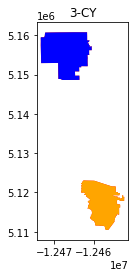

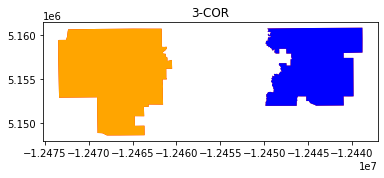

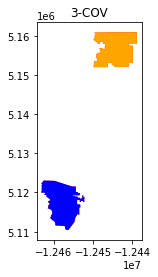

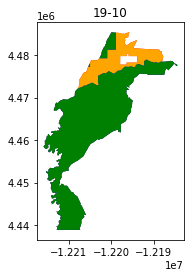

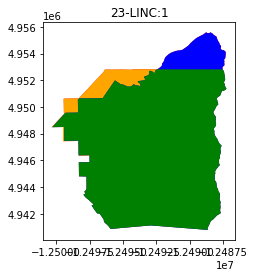

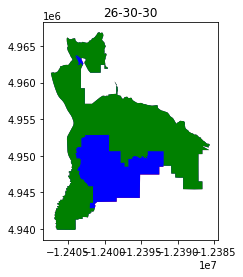

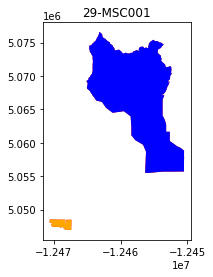

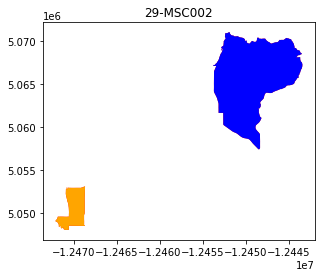

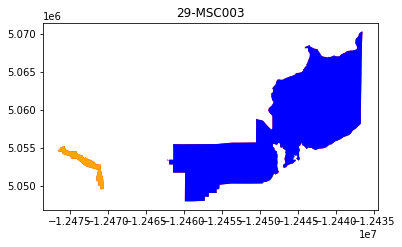

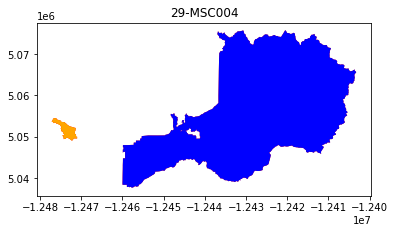

In [41]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))
    if (area > 1):
        count += 1
        name = source_geoms.at[i,"shp_ID"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [42]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2289, 1)
0 precincts w/ a difference of 0 km^2
2268 precincts w/ a difference between 0 and .1 km^2
11 precincts w/ a difference between .1 and .5 km^2
0 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
9 precincts w/ a difference greater than 5 km^2
